# Introduction

In this project, we aim to predict condition count, general multi-morbidity, and two specific comorbidities stroke and heart disease, and
diabetes and kidney disease. This notebook will walk through how this was achieved through data cleaning, EDA, and modeling using the kaggle dataset, Indicators of Heart Disease.

For analyses predicting overall condition count and multi-morbidity risk, all features were retained. However, for predicting specific comorbidity patterns (such as stroke/heart disease and diabetes/kidney disease), the race columns were dropped as it was found that they significantly overshadowed the other features. The overall analysis therefore focuses on how age, gender, and lifestyle factors play a role in different comorbidities.

From a healthcare perspective, modeling is often used as a tool to diagnose or screen patients. We decided to tune our models to prioritize recall to catch at-risk individuals. In the future, we could use that information to provide recommendations for lifestyle adjustments to reduce the risk of these diseases.


## Google CoLab Intialization: Run only once per Colab session

In [ ]:
# Initialization: run only once per Colab session
# Configuration Generated by ChatGPT
import os
from google.colab import drive

if "_DRIVE_MOUNTED" not in globals():
    print("🔄 Mounting Google Drive (first time this session)...")
    drive.mount('/content/drive')
    _DRIVE_MOUNTED = True
    print("✅ Mounted")
else:
    print("✅ Mounted")

if "_DRIVE_MOUNTED" in globals():
  #update relative paths to point at shared drive for pesistent storage
  new_root = "/content/drive/Shareddrives/5450FinalProject/"
  os.chdir(new_root)
  print(f"✅ Updated relative file path root to '{new_root}'")

  #print found files
  print(f"\nFiles found at '{new_root}':")
  for item in os.listdir():
    print(f"   - '{item}'")

else:
  print("‼️ Shared drive not mounted. Are you in a Google Colab environment?")

✅ Mounted
✅ Updated relative file path root to '/content/drive/Shareddrives/5450FinalProject/'

Files found at '/content/drive/Shareddrives/5450FinalProject/':
   - 'heart_2020_cleaned.csv'
   - 'Copy of CIS5450_Online_Project_FALL25_Details.docx'
   - 'Project Proposal.gdoc'
   - '5450FinalProject'


## Import Libraries

In [ ]:
#########################################
######## CIS 5450 FINAL PROJECT #########
######## Chelsea Patterson ##############
######## Brandy Bergher #################
######## Samantha Pathe #################
#########################################
import numpy as np
import pandas as pd
import seaborn as sns
import math
import imblearn


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, accuracy_score
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler

## Data Preparation


Descriptions for less self explantory variables (from kaggle):

* GENHEALTH - Would you say that in general your health is:
* PHYSICALHEALTH - Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?
* MENTALHEALTH - Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?
* DIFFWALK - Do you have serious difficulty walking or climbing stairs?
* PHYSICALACTIVITY - Do you exercise regularly outside of work?

For categorical features, specifically ones labeled "Yes/No", one-hot encoding converted "Yes" to 1 and "No" to 0. For age order and health order, enumeration was used so that the numeric values reflect the natural ordering. For example, the age group 18-24 was assigned a value of 0 and the health rating for Poor was also assigned a value of 0, with higher categories receiving increased values.



In [ ]:
# Read in file
df = pd.read_csv("heart_2020_cleaned.csv")
df.head()

# Copy of dataframe
df_cleaned = df.copy()

# Modify categorical cols/one hot encoding
df_cleaned['HeartDisease'] = df_cleaned['HeartDisease'].map({'No': 0, 'Yes': 1})
df_cleaned['Smoking'] = df_cleaned['Smoking'].map({'No': 0, 'Yes': 1})
df_cleaned['AlcoholDrinking'] = df_cleaned['AlcoholDrinking'].map({'No': 0, 'Yes': 1})
df_cleaned['Stroke'] = df_cleaned['Stroke'].map({'No': 0, 'Yes': 1})
df_cleaned['DiffWalking'] = df_cleaned['DiffWalking'].map({'No': 0, 'Yes': 1})
df_cleaned['Sex'] = df_cleaned['Sex'].map({'Male': 0, 'Female': 1})
df_cleaned['Diabetic'] = df_cleaned['Diabetic'].map({'No': 0, 'Yes': 1})
df_cleaned['PhysicalActivity'] = df_cleaned['PhysicalActivity'].map({'No': 0, 'Yes': 1})
df_cleaned['Asthma'] = df_cleaned['Asthma'].map({'No': 0, 'Yes': 1})
df_cleaned['KidneyDisease'] = df_cleaned['KidneyDisease'].map({'No': 0, 'Yes': 1})
df_cleaned['SkinCancer'] = df_cleaned['SkinCancer'].map({'No': 0, 'Yes': 1})
df_cleaned = pd.get_dummies(df_cleaned, columns=['Race'], prefix='Race')
age_order = ['18-24', '25-29', '30-34', '35-39', '40-44',
             '45-49', '50-54', '55-59', '60-64', '65-69',
             '70-74', '75-79', '80 or older']
df_cleaned['AgeCategory'] = df_cleaned['AgeCategory'].map({v: i for i, v in enumerate(age_order)})
health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
df_cleaned['GenHealth'] = df_cleaned['GenHealth'].map({v: i for i, v in enumerate(health_order)})

# Drop duplicates
df_cleaned = df_cleaned.drop_duplicates().reset_index(drop=True)

# Drop NA
df_cleaned = df_cleaned.dropna()

# View details
df_cleaned.head(5)
print(df_cleaned.dtypes)
print(len(df_cleaned))


HeartDisease                             int64
BMI                                    float64
Smoking                                  int64
AlcoholDrinking                          int64
Stroke                                   int64
PhysicalHealth                         float64
MentalHealth                           float64
DiffWalking                              int64
Sex                                      int64
AgeCategory                              int64
Diabetic                               float64
PhysicalActivity                         int64
GenHealth                                int64
SleepTime                              float64
Asthma                                   int64
KidneyDisease                            int64
SkinCancer                               int64
Race_American Indian/Alaskan Native       bool
Race_Asian                                bool
Race_Black                                bool
Race_Hispanic                             bool
Race_Other   

## Correlation Matrix or Scatter Plots: Identify strong relationships

### Condition Correlation Matrix
To understand which chronic conditions commonly co-occur, we calculated pairwise correlations among the six disease variables.

<Axes: >

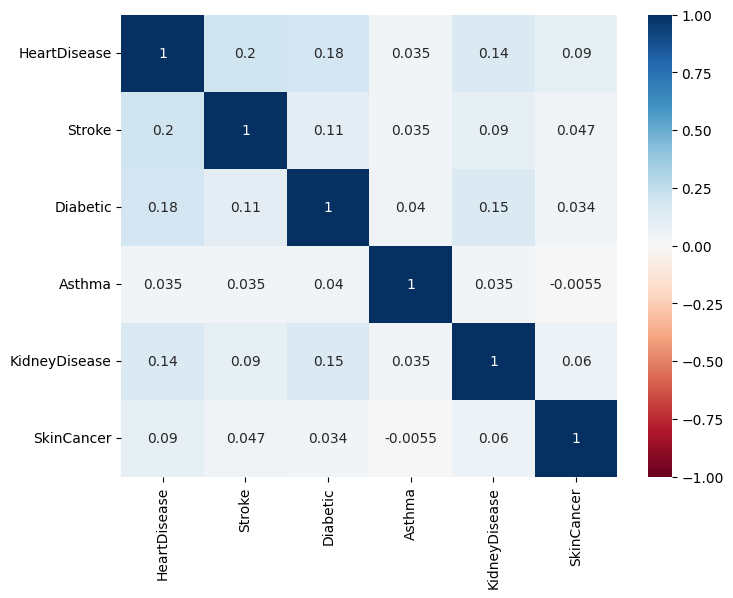

In [ ]:
# Disease only corr matrix
disease_cols = [
    'HeartDisease',
    'Stroke',
    'Diabetic',
    'Asthma',
    'KidneyDisease',
    'SkinCancer'
]

comorbid_df = df_cleaned[disease_cols].copy()
corr_matrix_comorbid = comorbid_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_comorbid, cmap='RdBu', vmin=-1, vmax=1, center=0, annot=True)

**Results:**

- 1:1 Relationships between diseases are all modest (r <= .20).
- Heart Disease/Stroke, Diabetes/Heart Disease have strongest correlations.
- There also is some relationship (r = 0.15) between Diabetes and Kidney Disease, which makes sense pathologically.
- These findings suggest that comorbidity patterns might be more complex than 1:1 relationships and justifies our use of K-Means clustering to identify more complex comorbidity patterns.

### Distribution of Condition Counts

To understand the overall burden of chronic disease in the population, we calculated the total number of conditions (0-6) for each individual and visualized the frequency distribution. This helps us identify potential class imbalance issues for modeling.

Text(0.5, 1.0, 'Distribution of Condition Counts')

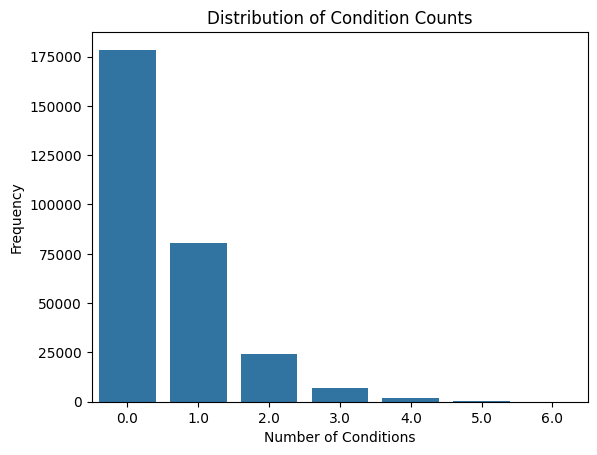

In [ ]:
condition_count = lambda x: x.sum()
condition_count_df = comorbid_df.copy()
condition_count_df['count'] = condition_count_df.apply(condition_count, axis=1)
#condition_count_df['count'].value_counts()
sns.countplot(data=condition_count_df, x='count')
plt.xlabel('Number of Conditions')
plt.ylabel('Frequency')
plt.title('Distribution of Condition Counts')

**Results:**

- Most individuals in the dataset are healthy, however there is a ~11% subset of the population that experiences at least 2+ diseases.

### Comorbidity Co-occurrence Rates

To understand which conditions commonly present together in our population, we calculated co-occurrence rates for each disease pair. For each primary condition (rows), we determined what percentage of patients with that condition also have each other condition (columns). This gives us a better idea about disease clustering patterns.

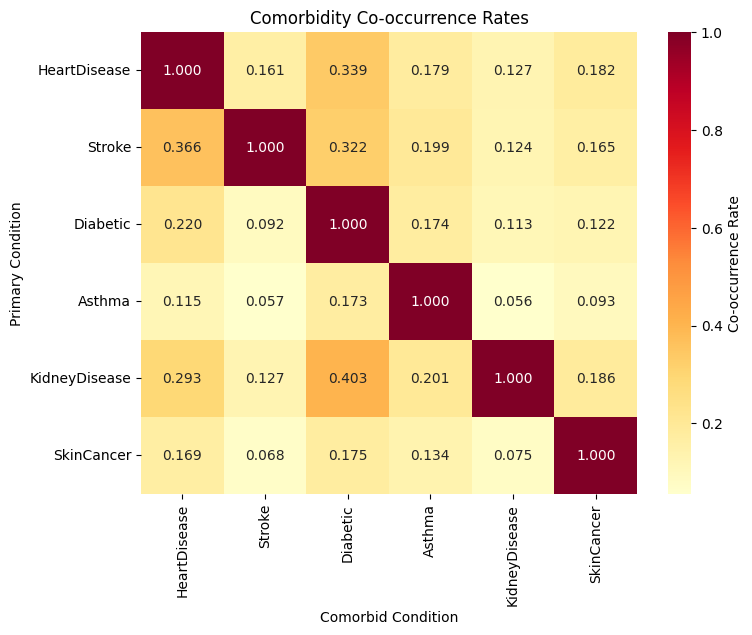

In [ ]:
comorbidity_summary = pd.DataFrame(index=disease_cols, columns=disease_cols)

for disease in disease_cols:
    disease_df = comorbid_df[comorbid_df[disease] == 1]
    for other_disease in disease_cols:
        comorbidity_summary.loc[disease, other_disease] = disease_df[other_disease].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(comorbidity_summary.astype(float), annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Co-occurrence Rate'})
plt.title('Comorbidity Co-occurrence Rates')
plt.xlabel('Comorbid Condition')
plt.ylabel('Primary Condition')
plt.show()

**Results:**

Highest co-occurence rates:

*   Kidney disease shows strongest comorbidity patterns with 40.3% also having Diabetes and 29.3% having Heart Disease
*   For Stroke, 36.6% also have HD and 32.2% have Diabetes
*   For Heart Disease, 33.9% also have Diabetes and 16.1% have Stroke






To better understand the demographics within the population that has comorbidities of kidney disease, heart disease, and diabetes, we sorted and grouped by both age and sex.

In [ ]:
# filter for the population that has heart disease, kidney disease, and diabetes as comborbidities
hd_kd_d_df = df_cleaned.copy()
hd_kd_d_df = hd_kd_d_df[(hd_kd_d_df['HeartDisease'] == 1) & (hd_kd_d_df['KidneyDisease'] == 1) & (hd_kd_d_df['Diabetic'] == 1)]
hd_kd_d_df['Sex'] = hd_kd_d_df['Sex'].apply(lambda x: 'Male' if x==0 else 'Female')
hd_kd_d_df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
43,1,30.23,1,0,0,6.0,2.0,1,Female,11,...,8.0,0,1,0,False,False,False,False,False,True
78,1,28.29,1,0,0,30.0,30.0,0,Female,10,...,9.0,0,1,0,False,False,False,False,False,True
149,1,23.34,0,0,0,0.0,0.0,0,Female,10,...,7.0,0,1,1,False,False,False,False,False,True
279,1,30.90,1,0,1,30.0,15.0,1,Female,9,...,4.0,1,1,0,False,False,False,False,False,True
281,1,35.44,1,0,0,30.0,0.0,1,Female,12,...,7.0,1,1,0,False,False,True,False,False,False


In [ ]:
# Group by age and sex and count the number of people that have all three diseases
disease_and_gender = hd_kd_d_df[['HeartDisease', 'KidneyDisease', 'Diabetic', 'Sex', 'AgeCategory']]
grouped = disease_and_gender.groupby(by=['AgeCategory', 'Sex']).size().reset_index(name='count')

# Account for 0 count for first two age categories
new_rows = pd.DataFrame([{'AgeCategory': 0, 'Sex': 'Female', 'count':0},{'AgeCategory': 1, 'Sex': 'Female', 'count':0},
 {'AgeCategory': 1, 'Sex': 'Male', 'count':0}])
concatenated_df = pd.concat([new_rows,grouped], axis=0)
concatenated_df.sort_values(by=['AgeCategory', 'Sex'], ascending=[True,False], inplace=True)
concatenated_df.head()


,AgeCategory,Sex,count
0,0,Male,2
0,0,Female,0
2,1,Male,0
1,1,Female,0
2,2,Male,2


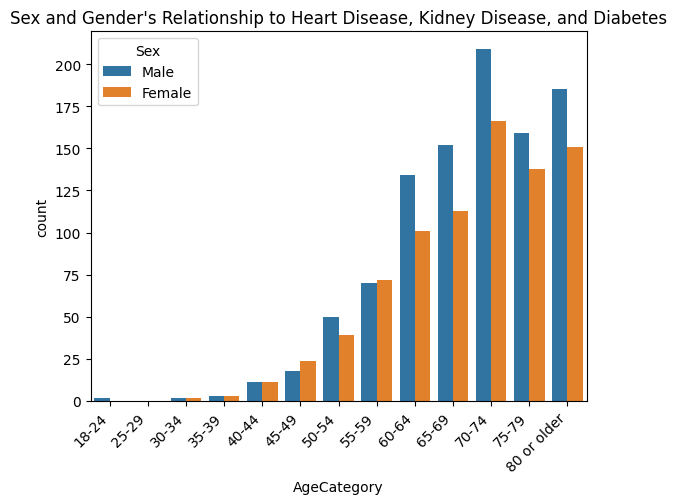

In [ ]:
g = sns.barplot(concatenated_df, x="AgeCategory", y="count", hue="Sex")

g.set_xticks(range(len(age_order)))
g.set_xticklabels(age_order, rotation = 45, ha='right')

g.set_title("Sex and Gender's Relationship to Heart Disease, Kidney Disease, and Diabetes")
plt.show()

**Results:** In the population with these comorbidities, as both men and women age, they see an increase in all three disease. This makes sense as we generally tend to have a higher rate of diseases as we age. Men showed a higher rate of these comorbidities, most notably betwen ages 60-79.

Within this population, we also wanted to understand which categorical lifestyle factors co-occured with these comorbidities. To do this, a co-occurence matrix was generated focused on the features smoking, alcohol drinking, difficulty walking, and physical activity.

In [ ]:
hd_kd_d_df.info()
cat_lifestyle_cols = ["Smoking", "AlcoholDrinking", "DiffWalking", "PhysicalActivity"]
cat_lifestyle_df = hd_kd_d_df[cat_lifestyle_cols]
cat_lifestyle_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 43 to 301660
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   HeartDisease                         1815 non-null   int64  
 1   BMI                                  1815 non-null   float64
 2   Smoking                              1815 non-null   int64  
 3   AlcoholDrinking                      1815 non-null   int64  
 4   Stroke                               1815 non-null   int64  
 5   PhysicalHealth                       1815 non-null   float64
 6   MentalHealth                         1815 non-null   float64
 7   DiffWalking                          1815 non-null   int64  
 8   Sex                                  1815 non-null   object 
 9   AgeCategory                          1815 non-null   int64  
 10  Diabetic                             1815 non-null   float64
 11  PhysicalActivity                

,Smoking,AlcoholDrinking,DiffWalking,PhysicalActivity
43,1,0,1,1
78,1,0,0,1
149,0,0,0,1
279,1,0,1,0
281,1,0,1,0


In [ ]:
cooccurrence = pd.DataFrame(index=cat_lifestyle_cols, columns=cat_lifestyle_cols)

for x in cat_lifestyle_cols:
    for y in cat_lifestyle_cols:
        cooccurrence.loc[x, y] = ((cat_lifestyle_df[x] == 1) & (cat_lifestyle_df[y] == 1)).mean()

cooccurrence.head()

,Smoking,AlcoholDrinking,DiffWalking,PhysicalActivity
Smoking,0.561983,0.009366,0.361983,0.256749
AlcoholDrinking,0.009366,0.013223,0.006061,0.007163
DiffWalking,0.361983,0.006061,0.619835,0.231956
PhysicalActivity,0.256749,0.007163,0.231956,0.469421


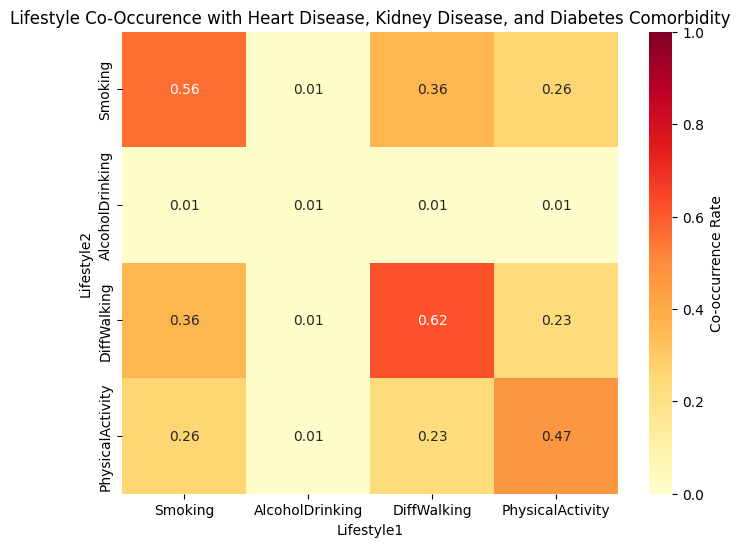

In [ ]:
# (Side note if you get an error running this cell, re-run the cell up top with all the imports)
plt.figure(figsize=(8,6))
h = sns.heatmap(cooccurrence.astype(float), annot=True, fmt='.2f', vmin=0, vmax=1, center=0.5, cmap='YlOrRd', cbar_kws={'label': 'Co-occurrence Rate'})
h.set_title('Lifestyle Co-Occurence with Heart Disease, Kidney Disease, and Diabetes Comorbidity')
h.set_xlabel('Lifestyle1')
h.set_ylabel('Lifestyle2')
plt.show()

**Results:** In this dataset filtered for individuals with heart disease, kidney disease, and diabetes, smoking and difficulty walking showed the highest co-occurence at 33%. Physical activity and smoking had the second highest co-occurence at 26%, and drinking alcohol had negligible co-occurence.

### Demographic Patterns in Comorbidity

To understand how conditions vary across patient populations, we analyzed average condition count by age, gender, and race. This analysis reveals whether comorbidity risk is uniformly distributed or concentrated in specific demographic groups.

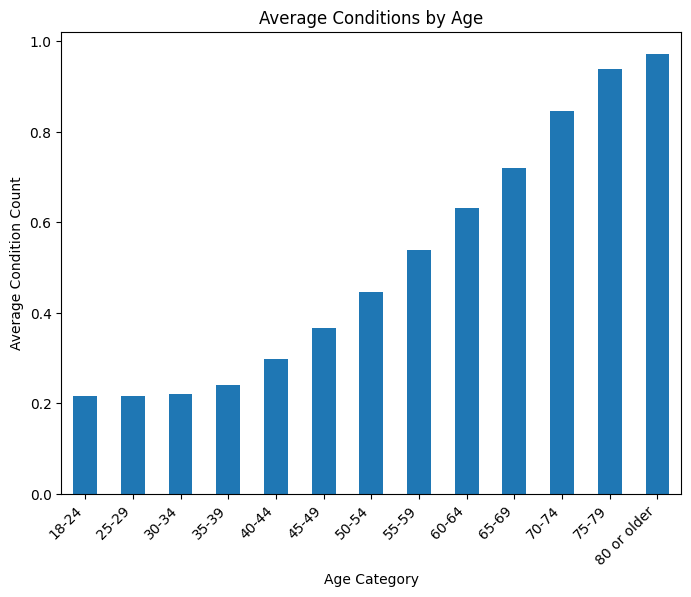

In [ ]:
# **Modified df_cleaned to include condition count column**
df_cleaned['condition_count'] = df_cleaned[disease_cols].sum(axis=1)

age_comorbid = df_cleaned.groupby(by='AgeCategory')['condition_count'].mean()
age_comorbid.head(15)
age_labels = {i: v for i, v in enumerate(age_order)}

plt.figure(figsize=(8, 6))
ax = age_comorbid.plot(kind='bar')
ax.set_xticklabels([age_labels[i] for i in age_comorbid.index], rotation=45, ha='right')
plt.xlabel('Age Category')
plt.ylabel('Average Condition Count')
plt.title('Average Conditions by Age')
plt.show()

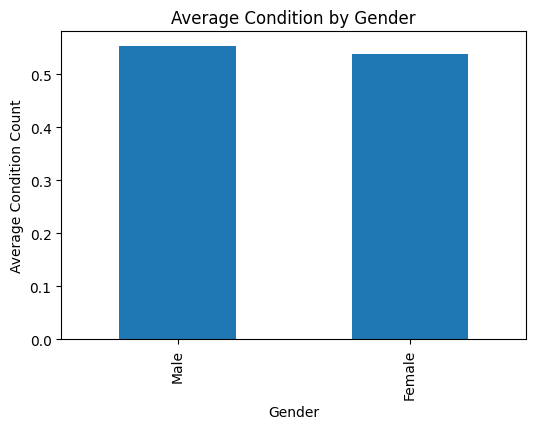

In [ ]:
gender_comorbid = df_cleaned.groupby(by='Sex')['condition_count'].mean()
gender_comorbid.index = gender_comorbid.index.map({
    0: 'Male',
    1: 'Female'
})

plt.figure(figsize=(6, 4))
gender_comorbid.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Average Condition Count')
plt.title('Average Condition by Gender')
plt.show()


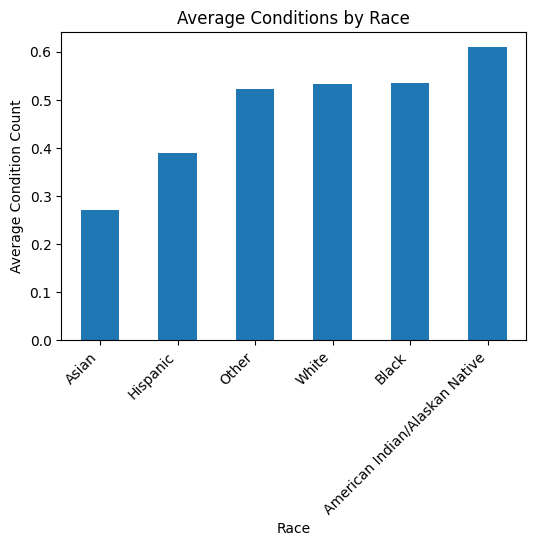

In [ ]:
race_comorbid = df.copy()
race_comorbid['HeartDisease'] = race_comorbid['HeartDisease'].map({'No': 0, 'Yes': 1})
race_comorbid['Stroke'] = race_comorbid['Stroke'].map({'No': 0, 'Yes': 1})
race_comorbid['Diabetic'] = race_comorbid['Diabetic'].map({'No': 0, 'Yes': 1})
race_comorbid['Asthma'] = race_comorbid['Asthma'].map({'No': 0, 'Yes': 1})
race_comorbid['KidneyDisease'] = race_comorbid['KidneyDisease'].map({'No': 0, 'Yes': 1})
race_comorbid['SkinCancer'] = race_comorbid['SkinCancer'].map({'No': 0, 'Yes': 1})
race_comorbid['condition_count'] = race_comorbid[disease_cols].sum(axis=1)
race_comorbid = (race_comorbid.groupby(by='Race')['condition_count'].mean().sort_values())
# race_comorbid.head(10)

plt.figure(figsize=(6, 4))
race_comorbid.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Race')
plt.ylabel('Average Condition Count')
plt.title('Average Conditions by Race')
plt.show()

**Results:**

- **Age:** Strong upward trend; condition count increases ~4.5x from youngest group (18-24 years: 0.22 conditions) to oldest age groups (80+ years: 0.97 conditions).

- **Gender:** Negligible difference between males (0.56) and females (0.54).

- **Race/Ethnicity:** Moderate variation exists across racial/ethnic groups (range: 0.27 to 0.61). Asian individuals show the lowest average condition count (0.27), while American Indian/Alaskan Native individuals show the highest (0.61). Other groups have averages in the 0.39-0.54 range. This variation may reflect differences in healthcare access, socioeconomic factors, or genetic predisposition.

**Summary:** Age emerges as the dominant demographic factor shaping comorbidity patterns, with increased disease burden accumulation across the lifespan. Gender shows no association, while racial/ethnic differences suggest potential disparities which could warrant further investigation.

Knowing that age is a dominant factor in shaping comorbidity patterns, we wanted to investigate the distribution of age on a per disease basis for men and women.

In [ ]:
disease_age_sex_cols = ['HeartDisease','Stroke','Diabetic','Asthma','KidneyDisease',
    'SkinCancer', "AgeCategory", "Sex"]

disease_age_sex_df = df_cleaned[disease_age_sex_cols].copy()
disease_age_sex_df['Sex'] = disease_age_sex_df['Sex'].apply(lambda x: 'Male' if x==0 else 'Female')

disease_age_sex_df.head()

,HeartDisease,Stroke,Diabetic,Asthma,KidneyDisease,SkinCancer,AgeCategory,Sex
0,0,0,1.0,1,0,1,7,Female
1,0,1,0.0,0,0,0,12,Female
2,0,0,1.0,1,0,0,9,Male
3,0,0,0.0,0,0,1,11,Female
4,0,0,0.0,0,0,0,4,Female


In [ ]:
# convert data to long format for visualization
melted_df = disease_age_sex_df.melt(id_vars=['AgeCategory', 'Sex'], value_vars= ['HeartDisease','Stroke','Diabetic','Asthma','KidneyDisease',
    'SkinCancer'], var_name='Disease', value_name='HasDisease')
melted_df.head()

,AgeCategory,Sex,Disease,HasDisease
0,7,Female,HeartDisease,0.0
1,12,Female,HeartDisease,0.0
2,9,Male,HeartDisease,0.0
3,11,Female,HeartDisease,0.0
4,4,Female,HeartDisease,0.0


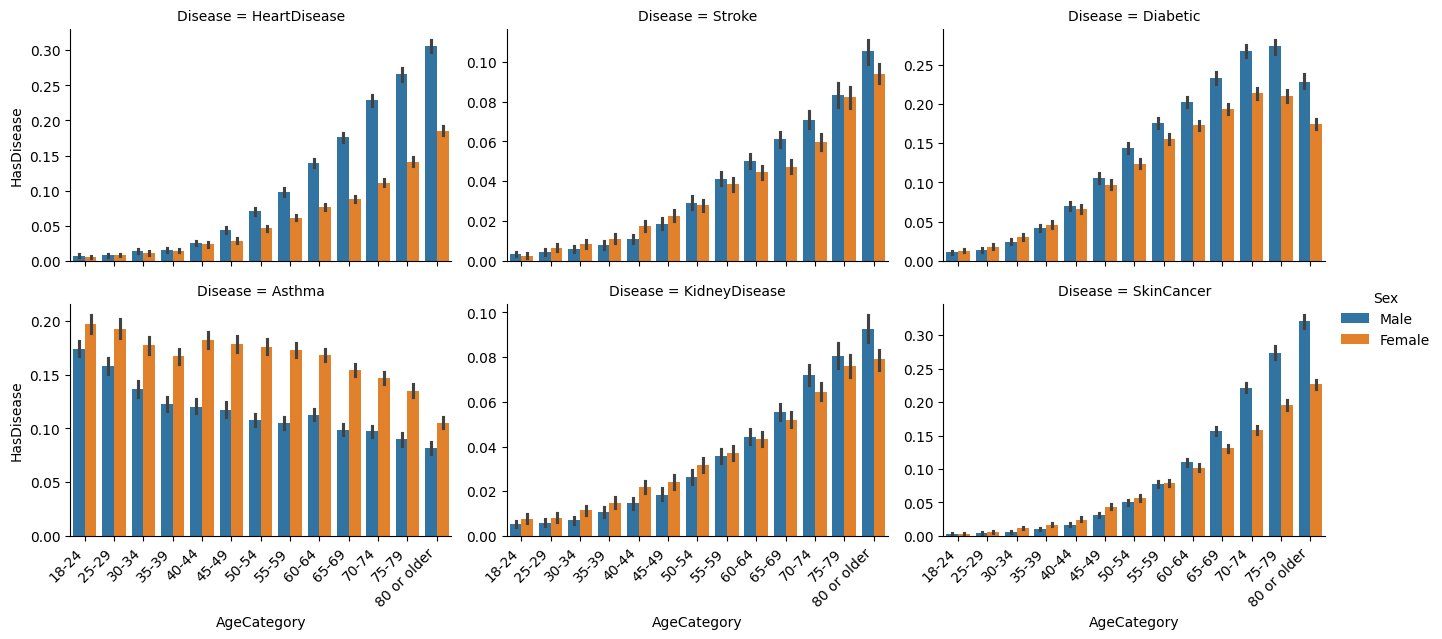

In [ ]:
grid = sns.catplot(data=melted_df, x="AgeCategory", y="HasDisease", hue="Sex", col="Disease", kind='bar', height=3, aspect=1.5, col_wrap=3, sharey=False)

for plot in grid.axes.flat:
    plot.set_xticks(range(len(age_order)))
    plot.set_xticklabels(age_order, rotation = 45, ha='right')

**Results**: As shown earlier, there generally seems to be a positive correlation between age and disease. There are a few diseases that seem to be more prevelant in older men compared to their female counterparts such as higher rates of heart disease and skin cancer. Interestingly, the only disease that is more prevelant in women is Asthma, and it seems to decrease for men and women as they age.

### Lifestyle Factors, Age, and Condition Count Correlation

This correlation matrix examines relationships between all lifestyle factors, age, and condition count. The purpose of this analysis is to give us a better idea of the broad factors that play a role in influencing overall disease burden and to potentially identify which features are most influential for predictive modeling in the supervised learning section.

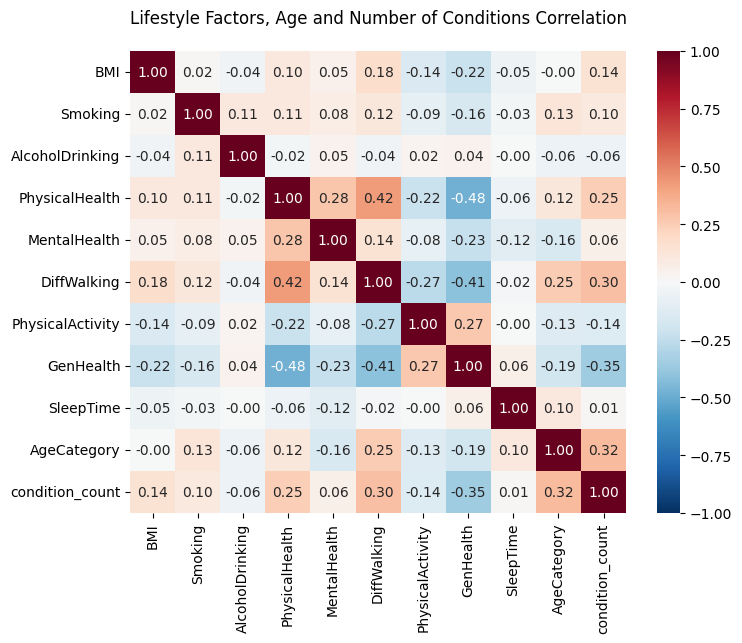

In [ ]:
lifestyle = [
    'BMI',
    'Smoking',
    'AlcoholDrinking',
    'PhysicalHealth',
    'MentalHealth',
    'DiffWalking',
    'PhysicalActivity',
    'GenHealth',
    'SleepTime',
    'AgeCategory',
    'condition_count'
]

lifestyle_comorbid_df = df_cleaned[lifestyle].copy()

corr_matrix_lifestyle = lifestyle_comorbid_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_lifestyle, cmap='RdBu_r', vmin=-1, vmax=1, center=0, annot=True, fmt='.2f')
plt.title('Lifestyle Factors, Age and Number of Conditions Correlation', fontsize=12, pad=20)
plt.show()



**Results:**

Strongest Predictors of Condition Count:
- GenHealth (r = -0.35): General health is the strongest single predictor. As general health increases, condition count decreases.
- AgeCategory (r = 0.32): Age shows moderate positive association with conditions, which confirms our findings from the demographic analysis.
- DiffWalking (r = 0.30): Difficulty walking is the strongest lifestyle risk factor.
- PhysicalHealth (r = 0.25): Poor physical health moderately predict higher condition count.
- PhysicalActivity (r = -0.14): Regular physical activity shows weak but consistent positive effect.

**Summary:** GenHealth perception, age and difficulty walking dominate prediction. Weak correlations for smoking, alcohol use, and sleep suggest these factors have limited impact on overall disease burden.

## KMeans Clustering (unsupervised)
Use KMeans to create clusters among the features.

### General Clustering

In [ ]:
# Kmeans dataframe
df_no_race = df_cleaned.drop(columns=[col for col in df_cleaned.columns if col.startswith('Race_')])
#race_cols = ['Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
#            'Race_Hispanic', 'Race_Other', 'Race_White']

df_kmeans_1 = df_no_race.copy()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_1)

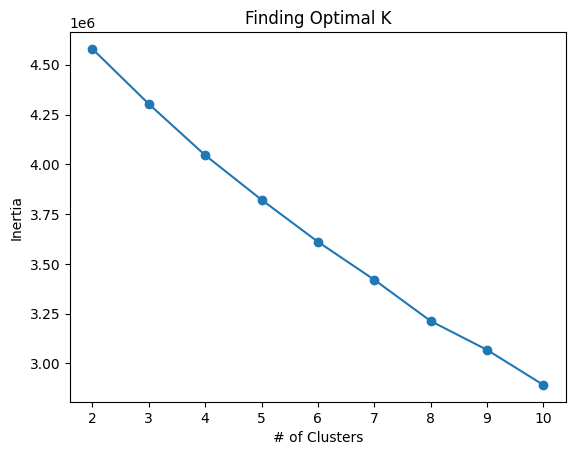

In [ ]:
# Fit kmeans
import matplotlib.pyplot as plt
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia of each K
plt.plot(K, inertia, 'o-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.show()

The elbow method in the graph helps estimate the optimal number of clusters by identifying where the rate of decrease in inertia begins to level off. In this case, the curve drops right after k = 5, so evaluating this seemed like a reasonable next step.

In [ ]:
# Used the above elbow graph to determine num clusters
kmeans = KMeans(n_clusters = 5, random_state=42)
cluster = kmeans.fit_predict(X_scaled)

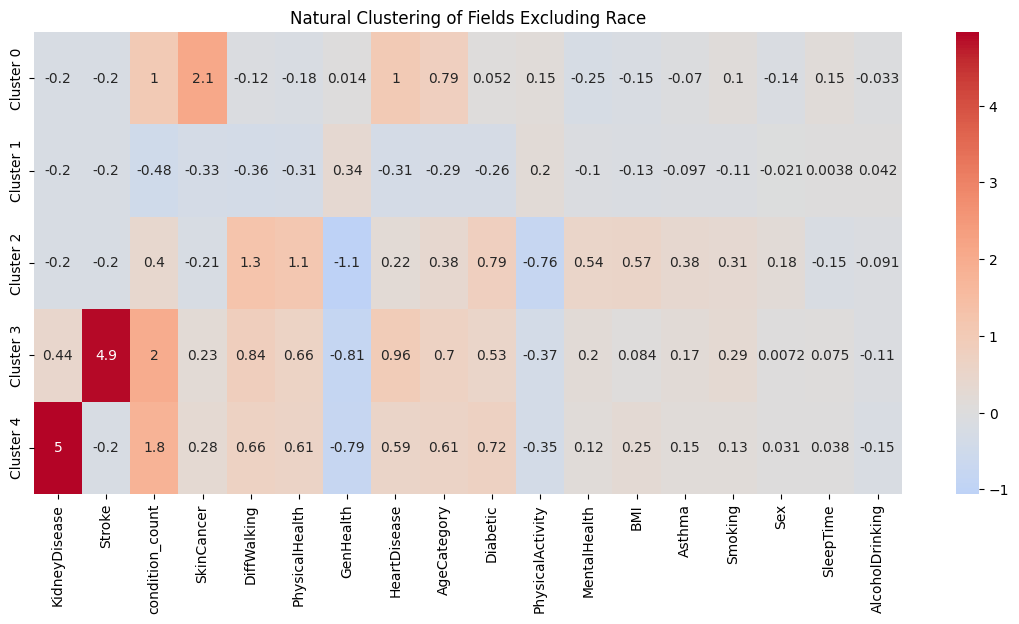

In [ ]:
# Make centroids df
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_kmeans_1.columns)
centroids.index = [f'Cluster {i}' for i in range(kmeans.n_clusters)]

# Get a spread of features
spread = centroids.max() - centroids.min()
sorted_spread = spread.sort_values(ascending=False).index

# Sort the centroids
sorted_centroids = centroids[sorted_spread]

# Display in Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(sorted_centroids, annot=True, cmap='coolwarm', center=0)
plt.title('Natural Clustering of Fields Excluding Race')
plt.show()


#### General Clustering Results
The purpose of the KMeans centroid heatmap is to show which features differ the most across clusters. By sorting features by their spread, the heatmap makes it easy to identify the attributes that contribute most to distinguishing the clusters.

*   Red indicates values above the overall average

*   Blue indicates values below average

*   Gray represents average values

Based on these patterns, a possible interpretation of the clusters is:

Cluster 0: Older group with elevated skin cancer rates

Cluster 1: Generally healthy but older adults

Cluster 2: Younger group with above average overall health

Cluster 3: High comorbidity group/stroke, heart disease, and mobility limitations

Cluster 4: Younger or middle aged group with notable physical impairments

### Comorbitity Clustering

In [ ]:
# Kmeans dataframe
df_kmeans_2 = df_no_race[disease_cols].copy()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_2)

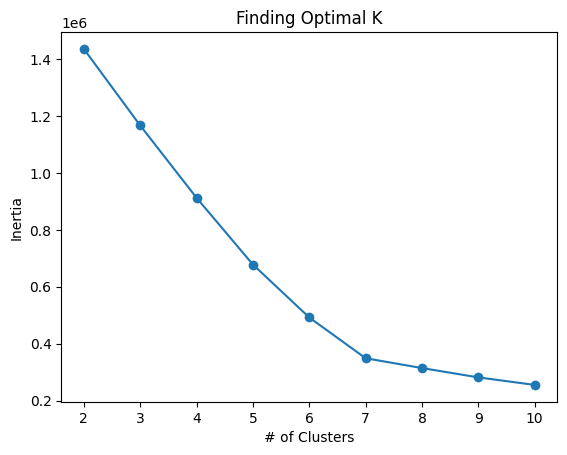

In [ ]:
# Fit kmeans
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia of each K
plt.plot(K, inertia, 'o-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.show()

The elbow method in the graph helps estimate the optimal number of clusters by identifying where the rate of decrease in inertia begins to level off. In this case, the curve drops right after k = 6, so evaluating this seemed like a reasonable next step.

In [ ]:
# Used the above elbow graph to determine num clusters
kmeans = KMeans(n_clusters = 6, random_state=42)
cluster = kmeans.fit_predict(X_scaled)

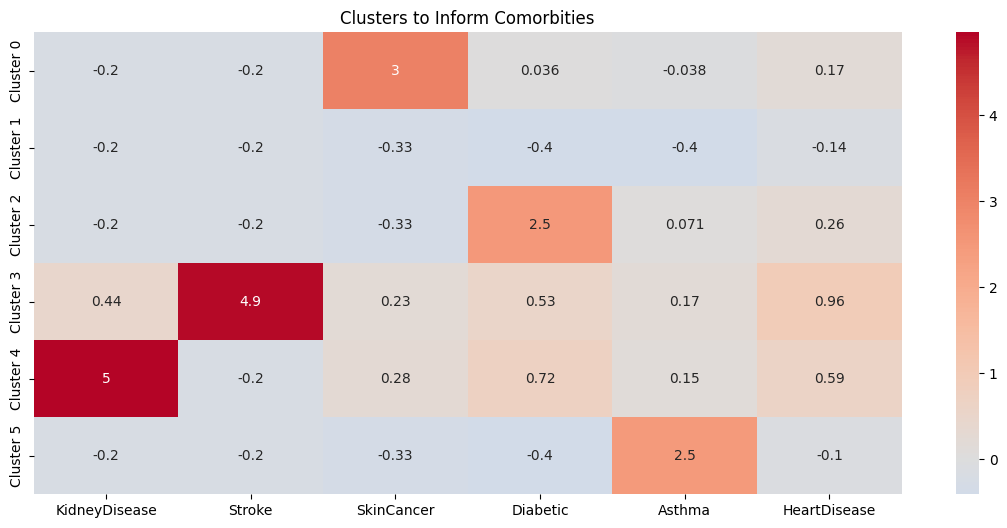

In [ ]:
# Make centroids df
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_kmeans_2.columns)
centroids.index = [f'Cluster {i}' for i in range(kmeans.n_clusters)]

# Get a spread of features
spread = centroids.max() - centroids.min()
sorted_spread = spread.sort_values(ascending=False).index

# Sort the centroids
sorted_centroids = centroids[sorted_spread]

# Display in Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(sorted_centroids, annot=True, cmap='coolwarm', center=0)
plt.title('Clusters to Inform Comorbities')
plt.show()

#### Comorbitity Results
The clustering revealed the following:

*   Cluster 3: Strong comorbitity between stroke and heart disease
*   Cluster 4: Strong comorbitity between diabetes and kidney disease

The focus will focus into the clusters with strong comorbitity.


In [ ]:
# Add cluster as a feature to kmeans df for later use in supervised models
# (COULD ADD TO MAIN DF IF WE WANT)
df_kmeans_2_cluster = df_no_race.copy()
df_kmeans_2_cluster['cluster'] = cluster
df_kmeans_2_cluster.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,condition_count,cluster
0,0,16.60,1,0,0,3.0,30.0,0,1,7,1.0,1,3,5.0,1,0,1,3.0,0
1,0,20.34,0,0,1,0.0,0.0,0,1,12,0.0,1,3,7.0,0,0,0,1.0,3
2,0,26.58,1,0,0,20.0,30.0,0,0,9,1.0,1,1,8.0,1,0,0,2.0,2
3,0,24.21,0,0,0,0.0,0.0,0,1,11,0.0,0,2,6.0,0,0,1,1.0,0
4,0,23.71,0,0,0,28.0,0.0,1,1,4,0.0,1,3,8.0,0,0,0,0.0,1


### Cluster 3,  Stroke & Heart Disease, and Lifestyle Clustering

In [ ]:
# Kmeans dataframe
# Isolating cluster 3 which is stroke and heart disease
comorbid_lifestyle_cols = ["BMI", "Smoking", "AlcoholDrinking", "PhysicalHealth",
                        "MentalHealth", "DiffWalking", "PhysicalActivity", "GenHealth", "SleepTime", "cluster"]

df_kmeans_3 = df_kmeans_2_cluster[comorbid_lifestyle_cols].copy()

df_kmeans_3_cluster_3 = df_kmeans_3[df_kmeans_3["cluster"] == 3]

df_kmeans_3_cluster_3 = df_kmeans_3_cluster_3.drop('cluster', axis=1)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_3_cluster_3)

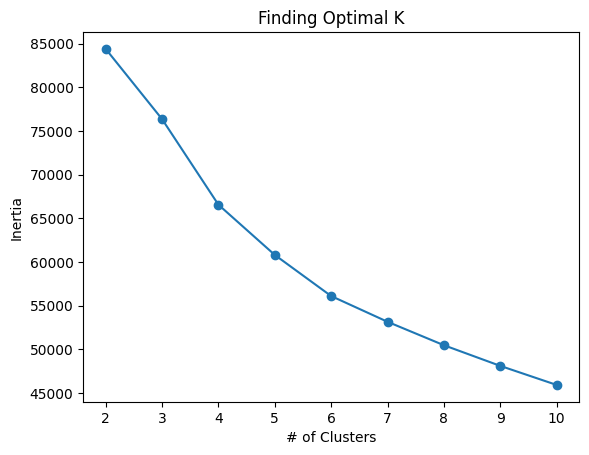

In [ ]:
# Fit kmeans
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia of each K
plt.plot(K, inertia, 'o-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.show()

The elbow method in the graph helps estimate the optimal number of clusters by identifying where the rate of decrease in inertia begins to level off. In this case, the curve drops right after k = 4, so evaluating this seemed like a reasonable next step.

In [ ]:
# Used the above elbow graph to determine num clusters
kmeans = KMeans(n_clusters = 4, random_state=42)
cluster = kmeans.fit_predict(X_scaled)

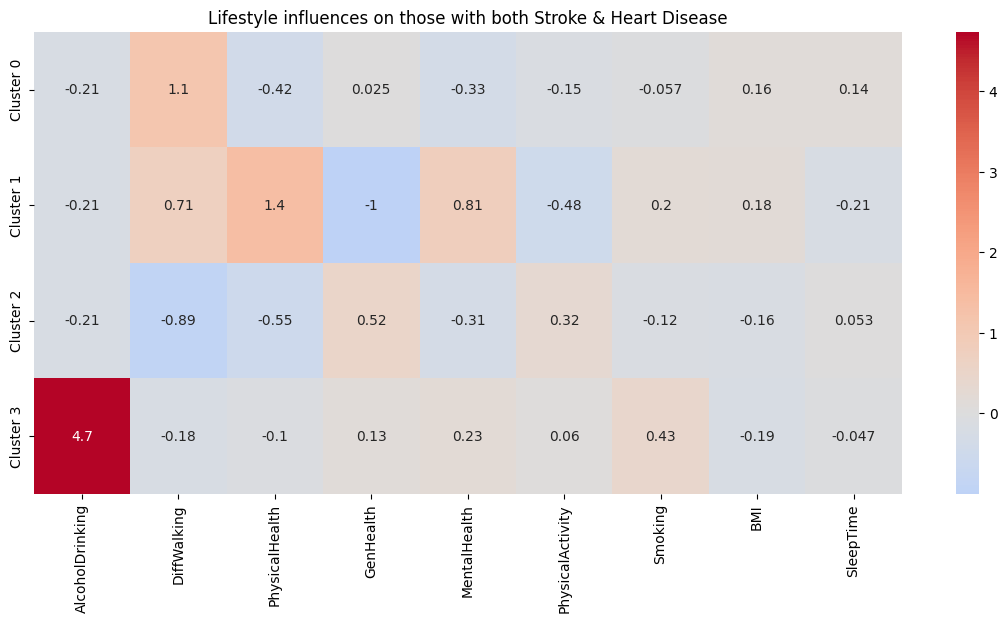

In [ ]:
# Make centroids df
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_kmeans_3_cluster_3.columns)
centroids.index = [f'Cluster {i}' for i in range(kmeans.n_clusters)]

# Get a spread of features
spread = centroids.max() - centroids.min()
sorted_spread = spread.sort_values(ascending=False).index

# Sort the centroids
sorted_centroids = centroids[sorted_spread]

# Display in Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(sorted_centroids, annot=True, cmap='coolwarm', center=0)
plt.title('Lifestyle influences on those with both Stroke & Heart Disease')
plt.show()

#### Cluster 3 Results: Stroke & Heart Disease
The results indicate that stroke and heart disease are strongly associated with alcohol consumption, and to a lesser extent, but still notable, physical health.

### Cluster 4, Diabetes & Kidney Disease, and Lifestyle Clustering

In [ ]:
# Kmeans dataframe
# Isolating cluster 4 which is kidney and diabetes

df_kmeans_4 = df_kmeans_2_cluster[comorbid_lifestyle_cols].copy()

df_kmeans_4_cluster_4 = df_kmeans_4[df_kmeans_4["cluster"] == 4]

df_kmeans_4_cluster_4 = df_kmeans_4_cluster_4.drop('cluster', axis=1)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_4_cluster_4)

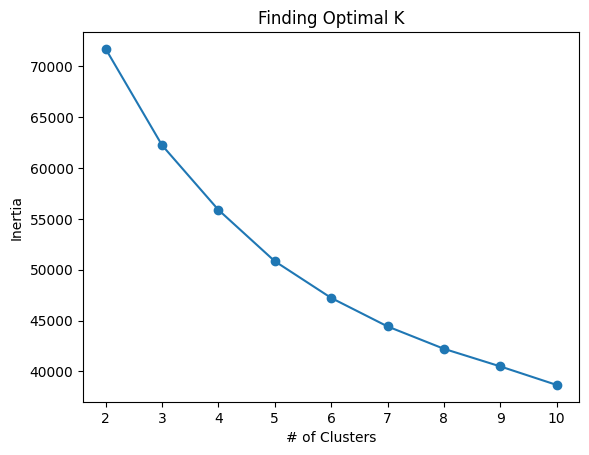

In [ ]:
# Fit kmeans
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia of each K
plt.plot(K, inertia, 'o-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.show()

The elbow method in the graph helps estimate the optimal number of clusters by identifying where the rate of decrease in inertia begins to level off. In this case, the curve has fewer drops right after k = 5, so evaluating this seemed like a reasonable next step.

In [ ]:
# Used the above elbow graph to determine num clusters
kmeans = KMeans(n_clusters = 5, random_state=42)
cluster = kmeans.fit_predict(X_scaled)

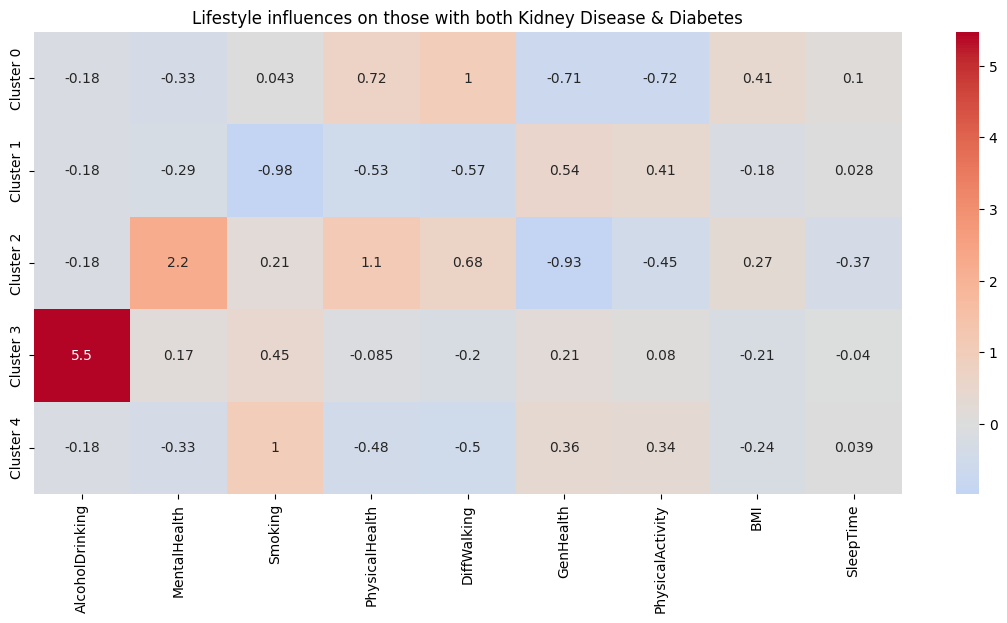

In [ ]:
# Make centroids df
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_kmeans_4_cluster_4.columns)
centroids.index = [f'Cluster {i}' for i in range(kmeans.n_clusters)]

# Get a spread of features
spread = centroids.max() - centroids.min()
sorted_spread = spread.sort_values(ascending=False).index

# Sort the centroids
sorted_centroids = centroids[sorted_spread]

# Display in Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(sorted_centroids, annot=True, cmap='coolwarm', center=0)
plt.title('Lifestyle influences on those with both Kidney Disease & Diabetes')
plt.show()

#### Cluster 4 Results: Diabetes & Kidney Disease
Similar to stroke and heart disease, it also appears that diabetes and kidney disease are strongly associated with alcohol consumption, and to a lesser extent, but still notable, mental health.

###Comorbitity & Lifestyle Clustering

In [ ]:
df_kmeans_5 = df_kmeans_2_cluster[comorbid_lifestyle_cols].copy()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_5)

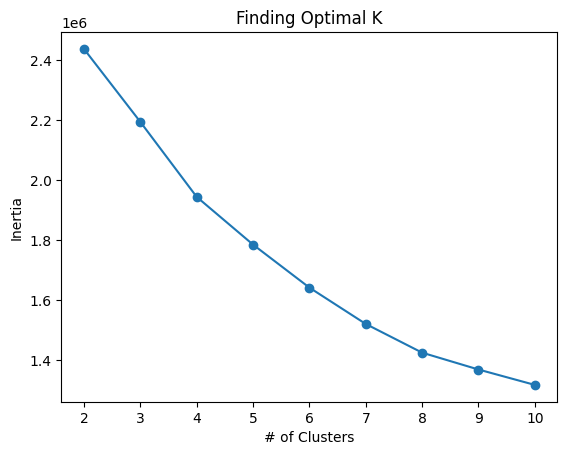

In [ ]:
# Fit kmeans
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia of each K
plt.plot(K, inertia, 'o-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.show()

The elbow method in the graph helps estimate the optimal number of clusters by identifying where the rate of decrease in inertia begins to level off. In this case, the curve has fewer drops right after k = 5, so evaluating this seemed like a reasonable next step.

In [ ]:
# Used the above elbow graph to determine num clusters
kmeans = KMeans(n_clusters = 5, random_state=42)
cluster = kmeans.fit_predict(X_scaled)

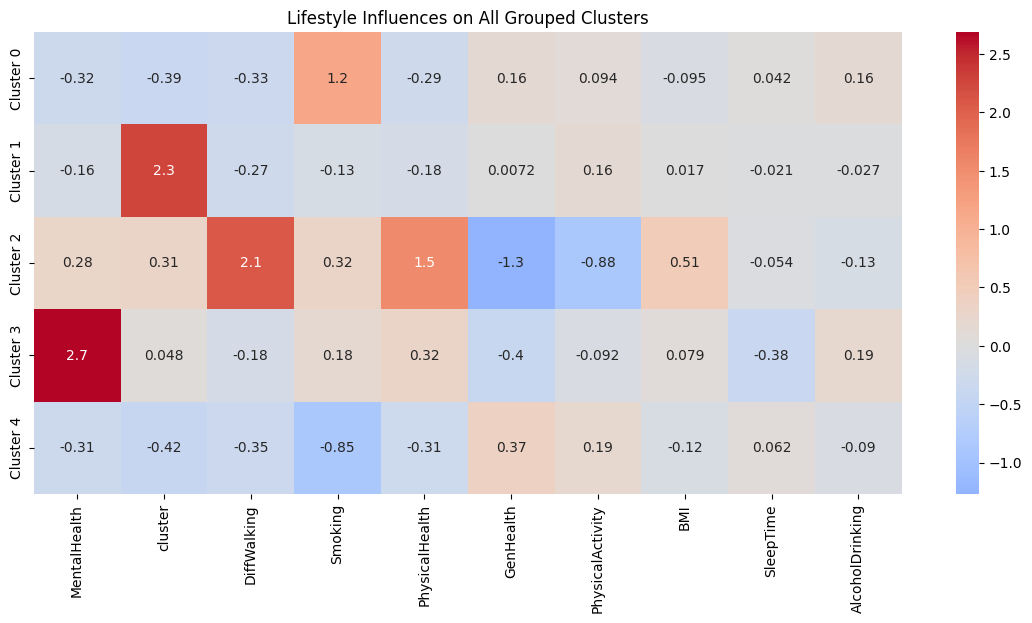

In [ ]:
# Make centroids df
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_kmeans_5.columns)
centroids.index = [f'Cluster {i}' for i in range(kmeans.n_clusters)]

# Get a spread of features
spread = centroids.max() - centroids.min()
sorted_spread = spread.sort_values(ascending=False).index

# Sort the centroids
sorted_centroids = centroids[sorted_spread]

# Display in Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(sorted_centroids, annot=True, cmap='coolwarm', center=0)
plt.title('Lifestyle Influences on All Grouped Clusters')
plt.show()

#### Comorbitity & Lifestyle Clustering Results

When attempting to perform secondary clustering on lifestyle factors across all clusters, the results were difficult to interpret. Clusters 0, 1, 2, and 5 showed minimal comorbidities in the original heatmap, so any subclusters formed in these groups were difficult to derive meaningful insights. Focusing the analysis on clusters 3 and 4, which contained the strongest comorbidity patterns, allowed for clearer interpretation and more actionable findings in future sections.

##Lifestyle Factors After Clustering

Once we found clusers with strong comorbitity, we analyzed the lifestyle factors within those clusters. First, we looked at the pairwise relationships for individuals with both stroke and heart disease (cluster 3).



In [ ]:
# individuals in cluster 3 (stroke and heart disease)
df_kmeans_3_cluster_3.head()
drop_cluster3_column = df_kmeans_3_cluster_3.copy()
continuous_vars = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
drop_cluster3_column.head(15)

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,GenHealth,SleepTime
1,20.34,0,0,0.0,0.0,0,1,3,7.0
35,32.98,1,0,10.0,0.0,1,1,0,4.0
40,22.60,1,0,0.0,10.0,0,0,3,8.0
49,27.46,1,0,15.0,0.0,0,1,0,8.0
59,27.20,1,0,0.0,0.0,0,0,3,8.0
75,25.54,1,0,0.0,0.0,0,0,1,6.0
123,23.67,1,0,0.0,0.0,0,1,3,9.0
135,23.39,1,0,0.0,3.0,1,1,2,9.0
142,31.48,0,1,20.0,20.0,1,0,1,7.0
163,26.75,0,0,0.0,0.0,0,1,2,7.0


In [ ]:
# map 0s and 1s back to yes and no for easier analysis in plots
drop_cluster3_column["Smoking"] = drop_cluster3_column['Smoking'].map({0: 'No', 1: 'Yes'})
drop_cluster3_column["AlcoholDrinking"] = drop_cluster3_column["AlcoholDrinking"].map({0: 'No', 1: 'Yes'})
drop_cluster3_column["DiffWalking"] = drop_cluster3_column["DiffWalking"].map({0: 'No', 1: 'Yes'})
drop_cluster3_column["PhysicalActivity"] = drop_cluster3_column["PhysicalActivity"].map({0: 'No', 1: 'Yes'})
drop_cluster3_column.head(15)

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,GenHealth,SleepTime
1,20.34,No,No,0.0,0.0,No,Yes,3,7.0
35,32.98,Yes,No,10.0,0.0,Yes,Yes,0,4.0
40,22.60,Yes,No,0.0,10.0,No,No,3,8.0
49,27.46,Yes,No,15.0,0.0,No,Yes,0,8.0
59,27.20,Yes,No,0.0,0.0,No,No,3,8.0
75,25.54,Yes,No,0.0,0.0,No,No,1,6.0
123,23.67,Yes,No,0.0,0.0,No,Yes,3,9.0
135,23.39,Yes,No,0.0,3.0,Yes,Yes,2,9.0
142,31.48,No,Yes,20.0,20.0,Yes,No,1,7.0
163,26.75,No,No,0.0,0.0,No,Yes,2,7.0


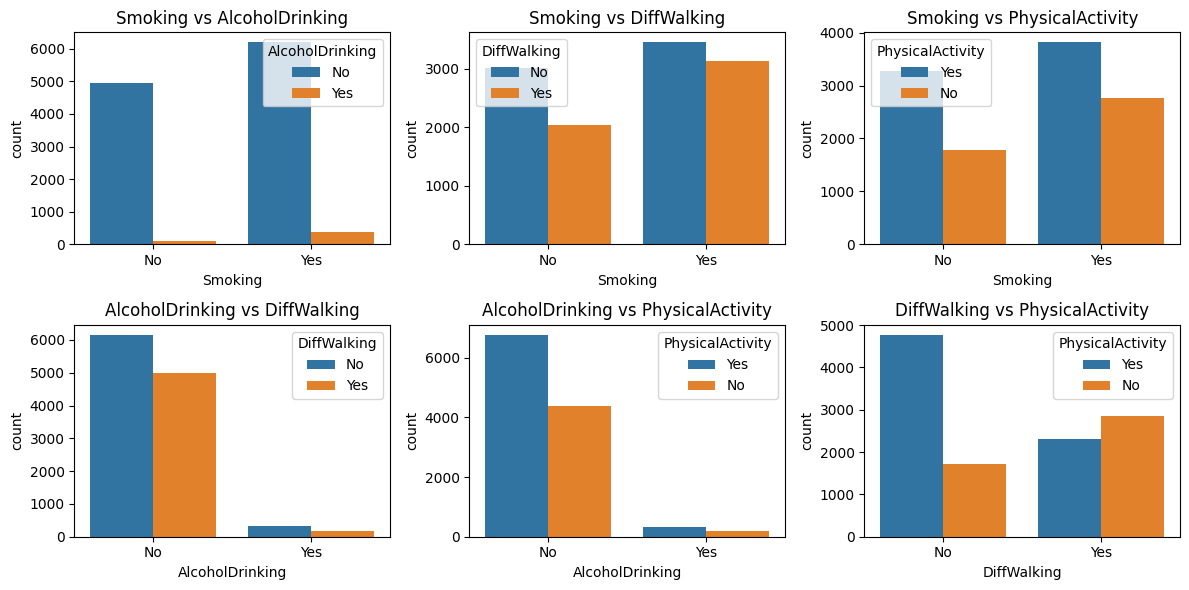

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax = ax.flatten()

index = 0

# perform pairwise analysis of all categorical lifestyle columns
for i in range(len(cat_lifestyle_cols)):
    for j in range(i+1, len(cat_lifestyle_cols)):
        cat1 = cat_lifestyle_cols[i]
        cat2 = cat_lifestyle_cols[j]
        sns.countplot(data=drop_cluster3_column, x=cat1, hue=cat2, ax=ax[index])
        ax[index].set_title(f'{cat1} vs {cat2}')
        index +=1
plt.tight_layout()
plt.show()

Results:


*   Abstaining from drinking alchol was positively correlated with this population's amount of physical activity.
*   Difficulty walking was strongly correlated with ones ability to do physical activity
*   Those who smoked reported a more difficulty walking than their non smoking counterparts






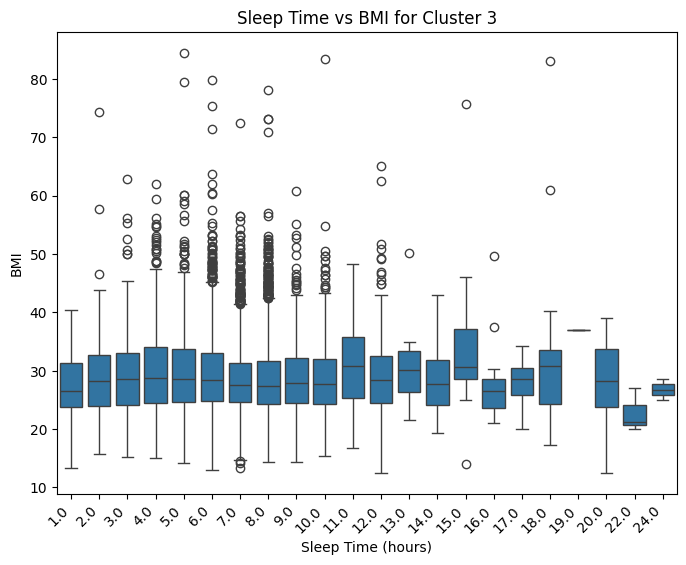

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=drop_cluster3_column, x="SleepTime", y="BMI")
ax.set_title("Sleep Time vs BMI for Cluster 3")
ax.set_xlabel("Sleep Time (hours)")
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
plt.show()

Reuslts: Between 6-10 hours of sleep correlated with lower BMIs with a few outliers at 14,16 and >20 hours of sleep. This tracks with the recommended hours of sleep for most adults. People who slept for less or more than the 6-10 hours tended to have higher BMIs.

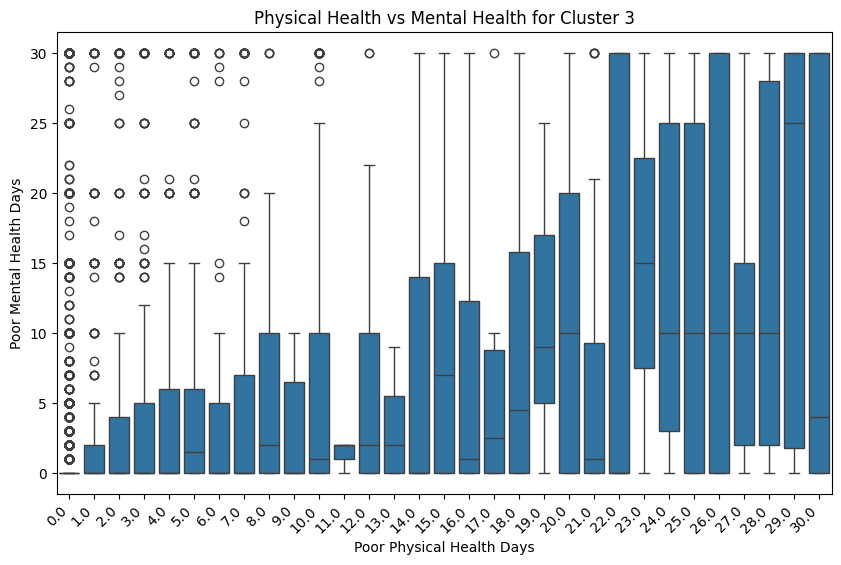

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=drop_cluster3_column, x="PhysicalHealth", y="MentalHealth")
ax.set_title("Physical Health vs Mental Health for Cluster 3")
ax.set_xlabel("Poor Physical Health Days")
ax.set_ylabel("Poor Mental Health Days")
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
plt.show()

Reuslts: As people have more days with poor physical health during the month, we see a positive correlation with more poor mental health days.

Now we'll look at the relationships between lifestyle factors for Cluster 4 (Kidney Disease and Diabetes)

In [ ]:
df_kmeans_4_cluster_4.head()
drop_cluster4_column = df_kmeans_4_cluster_4.copy()
drop_cluster4_column.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,GenHealth,SleepTime
18,29.86,1,0,0.0,0.0,1,0,1,5.0
39,21.93,0,0,3.0,2.0,0,1,1,4.0
43,30.23,1,0,6.0,2.0,1,1,1,8.0
65,26.63,0,0,20.0,0.0,0,1,1,6.0
66,34.01,1,0,14.0,0.0,0,0,2,7.0


In [ ]:
drop_cluster4_column["Smoking"] = drop_cluster4_column["Smoking"].map({0: 'No', 1: 'Yes'})
drop_cluster4_column["AlcoholDrinking"] = drop_cluster4_column["AlcoholDrinking"].map({0: 'No', 1: 'Yes'})
drop_cluster4_column["DiffWalking"] = drop_cluster4_column["DiffWalking"].map({0: 'No', 1: 'Yes'})
drop_cluster4_column["PhysicalActivity"] = drop_cluster4_column["PhysicalActivity"].map({0: 'No', 1: 'Yes'})
drop_cluster4_column.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,GenHealth,SleepTime
18,29.86,Yes,No,0.0,0.0,Yes,No,1,5.0
39,21.93,No,No,3.0,2.0,No,Yes,1,4.0
43,30.23,Yes,No,6.0,2.0,Yes,Yes,1,8.0
65,26.63,No,No,20.0,0.0,No,Yes,1,6.0
66,34.01,Yes,No,14.0,0.0,No,No,2,7.0


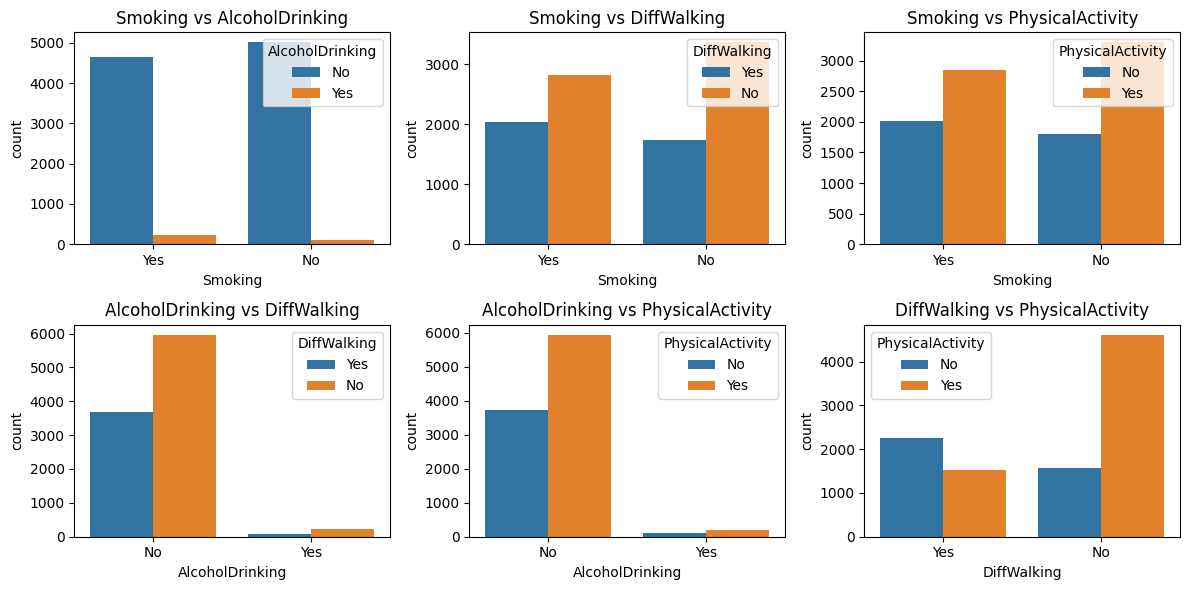

In [ ]:
fig1, ax1 = plt.subplots(2,3, figsize=(12,6))
ax1 = ax1.flatten()

index = 0

for i in range(len(cat_lifestyle_cols)):
    for j in range(i+1, len(cat_lifestyle_cols)):
        cat1 = cat_lifestyle_cols[i]
        cat2 = cat_lifestyle_cols[j]
        sns.countplot(data=drop_cluster4_column, x=cat1, hue=cat2, ax=ax1[index])
        ax1[index].set_title(f'{cat1} vs {cat2}')
        index +=1
plt.tight_layout()
plt.show()

Results:
We see the same patterns for these lifestyle factors as we saw for the population in cluster 3.

*   Abstaining from drinking alchol was positively correlated with this population's amount of physical activity.
*   Difficulty walking was strongly correlated with ones ability to do physical activity
*   Those who smoked reported a more difficulty walking than their non smoking counterparts. One noteable difference from cluster 3 is that those that didn't smoke also reported more physical activity in general.






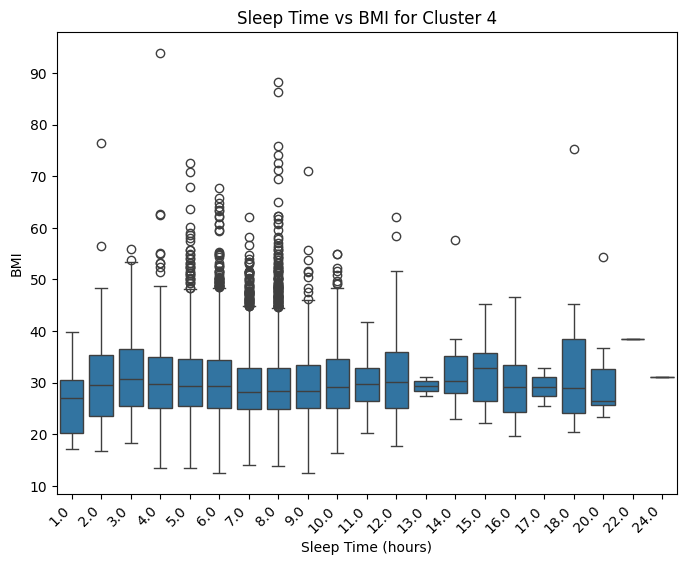

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=drop_cluster4_column, x="SleepTime", y="BMI")
ax.set_title("Sleep Time vs BMI for Cluster 4")
ax.set_xlabel("Sleep Time (hours)")
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
plt.show()

Similar to the population in cluster 3, we see lower BMIs associated with people who get 7-9 hours of sleep and higher BMIs outside that window.

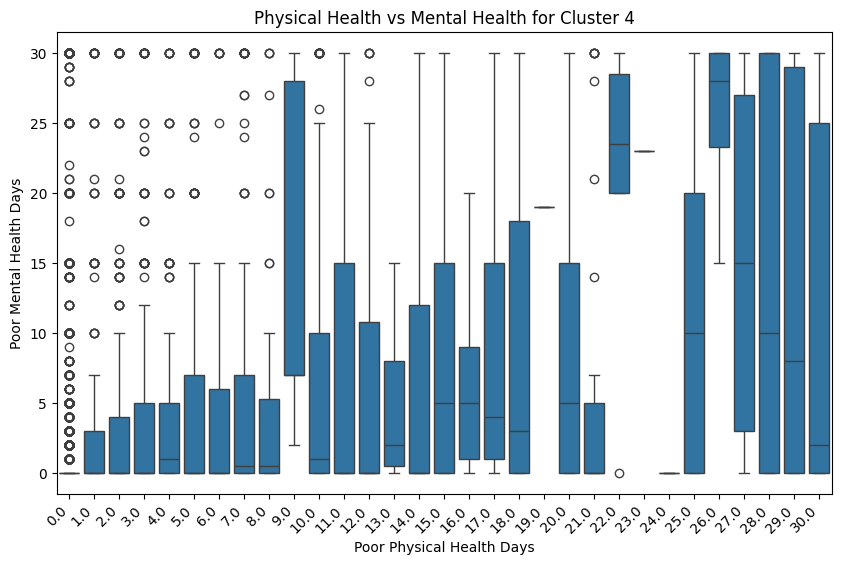

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=drop_cluster4_column, x="PhysicalHealth", y="MentalHealth")
ax.set_title("Physical Health vs Mental Health for Cluster 4")
ax.set_xlabel("Poor Physical Health Days")
ax.set_ylabel("Poor Mental Health Days")
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
plt.show()

We also see a similar trend to the population in cluster 3 where more poor physical health days correlates to more poor mental health days.

# Supervised Learning


## Predicting Condition Count and Multi-Morbidity
### Linear Regression and Random Forest: Predicting Condition Count

To establish a baseline model for predicting disease burden, we trained Linear Regression and Random Forest models using demographic and lifestyle factors as features to predict condition count (0-6).

### Linear Regression

In [ ]:
# Filter original DF for features (all columns except conditions and condition count)
lr_features = df_cleaned.copy()
drop_cols = disease_cols + ['condition_count']
lr_features.drop(drop_cols, inplace=True, axis=1)

# condition_count = target
lr_target = df_cleaned['condition_count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(lr_features, lr_target, test_size=0.2, random_state=42)


In [ ]:
# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict using trained model on test/train data
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Evaluate/Score

# R squared
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Root MSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R2 score (training): {r2_score_train}")
print(f"R2 score (test): {r2_score_test}")
print(f"MAE (training): {mae_train}")
print(f"MAE (test): {mae_test}")
print(f"RMSE (training): {rmse_train}")
print(f"RMSE (test): {rmse_test}")


R2 score (training): 0.2155130420639524
R2 score (test): 0.214003811746021
MAE (training): 0.5483943676559397
MAE (test): 0.5471518212348486
RMSE (training): 0.7204797212161641
RMSE (test): 0.7194804359269499


#### Linear Regression - Results and Summary:

**Results:**
- R^2 (Train): 0.215, R^2 (Test): 0.214
- MAE (Train): 0.548, MAE (Test): 0.547
- RMSE (Train): 0.720, RMSE (Test): 0.719

**Summary:**
- Train and test metrics are nearly identical, which indicates no overfitting
- Model explains only ~21% of variance in condition count
- Predictions are off by ~0.55 conditions on average
- Model's weak predictive capability reflects EDA correlations
- Model generalizes consistently but cannot reliably predict exact disease count

Overall, these results suggest that the relationship between lifestyle and demographic factors with condition count may be more complex than what can be captured by a linear model. Based on these results, we decided to train a Random Forest model as an alternative to see if we can identify non-linear patterns.

### Random Forest Regression

In [ ]:
# Cell takes awhile to run (5-6mins), commenting it out after running

# param_grid = {
#     'max_depth': [3, 5, 7, 10, 12]
# }

# rf_search = GridSearchCV(
#     RandomForestRegressor(random_state=42),
#     param_grid,
#     cv=3,
#     scoring='r2'
# )

# rf_search.fit(X_train, y_train)
# print(f"Best params: {rf_search.best_params_}")
# print(f"Best CV R2: {rf_search.best_score_}")

# y_pred_test = rf_search.predict(X_test)
# print(f"Test R2: {r2_score(y_test, y_pred_test)}")

# ** Results **
# Best params: {'max_depth': 10}
# Best CV R2: 0.23840207592625276
# Test R2: 0.24055281064372824

Best params: {'max_depth': 10}
Best CV R2: 0.23840207592625276
Test R2: 0.24055281064372824


In [ ]:
rf = RandomForestRegressor(random_state=42, max_depth=10)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# R squared
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Root MSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R2 score (training): {r2_score_train}")
print(f"R2 score (test): {r2_score_test}")
print(f"MAE (training): {mae_train}")
print(f"MAE (test): {mae_test}")
print(f"RMSE (training): {rmse_train}")
print(f"RMSE (test): {rmse_test}")

R2 score (training): 0.27926750210730267
R2 score (test): 0.24055281064372824
MAE (training): 0.5269924547897924
MAE (test): 0.5366033891570351
RMSE (training): 0.690583106402591
RMSE (test): 0.7072249257638398


In [ ]:
# Get feature importances
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
9,GenHealth,0.448210
7,AgeCategory,0.307622
0,BMI,0.093724
5,DiffWalking,0.038795
10,SleepTime,0.024347
3,PhysicalHealth,0.022262
6,Sex,0.019103
4,MentalHealth,0.014500
16,Race_White,0.006643
1,Smoking,0.004588


<Figure size 600x400 with 0 Axes>

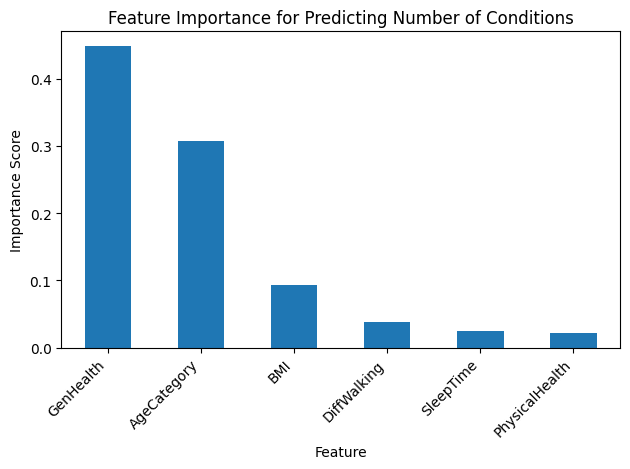

In [ ]:
plt.figure(figsize=(6, 4))
top_features = feature_importance_df.head(6)
top_features.set_index('Feature').plot(kind='bar', legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance for Predicting Number of Conditions')
plt.tight_layout()
plt.show()

#### Random Forest - Results and Summary:

**Model Setup:**
After initializing the Random Forest with default parameters, we encountered severe overfitting: train R^2 reached 0.852 while test R^2 dropped to 0.124. To address this, we tuned `max_depth` using GridSearchCV with 3-fold cross-validation across values [3, 5, 7, 10, 12] . GridSearchCV identified `max_depth=10` as optimal, which eliminated the train-test gap between models.

**Results:**
- R^2 (Train): 0.279, R^2 (Test): 0.240
- MAE (Train): 0.527, MAE (Test): 0.537
- RMSE (Train): 0.691, RMSE (Test): 0.707

**Feature Importance:**
- GenHealth: 0.448
- AgeCategory: 0.308
- Confirms EDA findings

**Summary:**
- Train and test metrics are nearly identical, which indicates no overfitting occurred
- Model explains 24% of variance, marginally better than linear regression but still low
- Predictions remain off by ~0.53 conditions on average, roughly the same as linear regression
- Overall performance improvement is minimal

### Logistic Regression and Random Forest: Predicting Multi-Morbidity Risk (2+ Conditions)

Since clinical decision-making often requires binary risk stratification, we propose models to identify who is at-risk for multiple conditions versus not. We trained Logistic Regression and Random Forest models to predict multi-morbidity (2+ conditions vs 0-1 conditions) based on demographics and lifestyle factors.

In [ ]:
# Create new df for logistic regression
func = lambda x: 0 if x['condition_count'] < 2 else 1
logistic_reg_df = df_cleaned.copy()
logistic_reg_df['has_comorbidities'] = logistic_reg_df.apply(func, axis=1)
#logistic_reg_df['has_comorbidities'].value_counts()

log_reg_target = logistic_reg_df['has_comorbidities']
drop_cols = disease_cols + ['condition_count', 'has_comorbidities']
log_reg_features = logistic_reg_df.drop(drop_cols, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(log_reg_features, log_reg_target, test_size=0.2, random_state=42)

In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

Train accuracy: 0.7346478102501839
Test accuracy: 0.7364262872582383
Precision: 0.2683427128806606
Recall: 0.7725620835857057
ROC-AUC: 0.7521939444589797
Confusion Matrix:
[[37962 13911]
 [ 1502  5102]]


#### Logistic Regression - Results and Summary:

**Model Setup:**
When we initialzed with default parameters we had two issues: First, the model failed to converge. Second, the model predicted class 0 for nearly all samples, achieving 88% accuracy by simply ignoring the minority class. The latter was due to class imbalance: 88.5% of the population has 0-1 conditions (class 0) while only 11.5% have 2+ conditions (class 1). To address class imbalance, we applied `class_weight='balanced'`, which penalizes misclassification of the rare class (multi-morbidity) more heavily. This forced the model to be more sensitive to identifying at-risk patients. To address convergence we set the max iterations to 1000.

**Results:**
- Accuracy (Train): 0.735, Accuracy (Test): 0.736
- Precision: 0.268
- Recall: 0.773
- ROC-AUC: 0.752
- Confusion Matrix: 37,964 true negatives, 13,909 false positives, 1,502 false negatives, 5,102 true positives

**Summary:**
- Model catches 77% of actual at-risk individuals but flags many healthy people as at-risk (false positives)
- Train/test metrics are nearly identical, indicating no overfitting
- ROC-AUC of 0.752 indicates model can differentiate moderately well between low-risk and high-risk categories
- Model achieves clinically meaningful performance; Few people with actual multi-morbidity are missed

## Decision Tree: Predicting Multi-Morbidity Risk (2+ Conditions)

We also trained a decision tree model to predict multi-morbidity (2+ conditions vs 0-1 conditions) based on demographics and lifestyle factors due to its ability to handle complex relationships while still being easy to interpret.

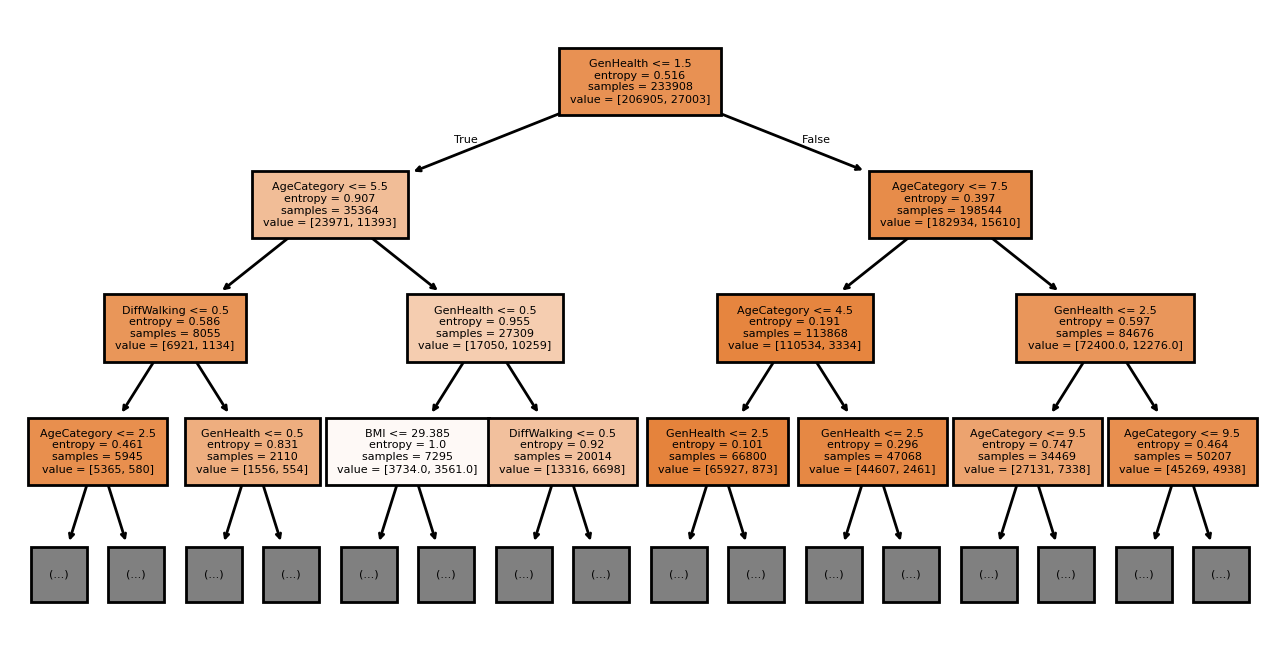

Training Accuracy for decision tree: 0.8867
Testing Accuracy for decision tree: 0.8887
Precision for decision tree: 0.5568
Recall for decision tree: 0.0698
Train ROC-AUC: 0.8077
Test ROC-AUC: 0.8082
Confusion Matrix:
[[51506   367]
 [ 6143   461]]


In [ ]:
# Train decision tree model
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt = dt.fit(X_train, y_train)
# Predict using trained model on test/train data
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

y_pred_proba_train = dt.predict_proba(X_train)[:, 1]
y_pred_proba_test = dt.predict_proba(X_test)[:, 1]

# Evaluate/Score

dt_train_acc = accuracy_score(y_train, y_hat_train)
dt_test_acc = accuracy_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
train_auc = roc_auc_score(y_train, y_pred_proba_train)
test_auc = roc_auc_score(y_test, y_pred_proba_test)
cm = confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(8,4), dpi=200)
plot_tree(dt, max_depth=3, fontsize=4, feature_names=X_train.columns, filled=True)
plt.show()

print(f'Training Accuracy for decision tree: {dt_train_acc:.4f}')
print(f'Testing Accuracy for decision tree: {dt_test_acc:.4f}')
print(f'Precision for decision tree: {precision:.4f}')
print(f'Recall for decision tree: {recall:.4f}')
print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")
print('Confusion Matrix:')
print(cm)

In [ ]:
feature_names = X_train.columns
dt_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt.feature_importances_})
dt_feature_importance_df = dt_feature_importance_df.sort_values('Importance', ascending=False)
dt_feature_importance_df

,Feature,Importance
9,GenHealth,0.548670
7,AgeCategory,0.427630
5,DiffWalking,0.017706
0,BMI,0.005994
1,Smoking,0.000000
4,MentalHealth,0.000000
3,PhysicalHealth,0.000000
6,Sex,0.000000
2,AlcoholDrinking,0.000000
8,PhysicalActivity,0.000000


**Results:**
*   Training Accuracy: 0.8867, Testing Accuracy: 0.8887 - similar values for training and testing indicates no overfitting
*   Precision: 0.5568
*   Recall: 0.0698
*   Train ROC-AUC: 0.8077, Test ROC-AUC: 0.8082
*   Confusion Matrix: 51506 true negatives, 367 false positives, 6143 false negatives, 461 true positives

Based on the plot of the tree and the feature importance, general health was the biggest contributer (54.87%), followed by age (42.8%) to determining a person multi-morbidity risk.

One issue with this classifer is that it overfit to the training data, showing a training accuracy of 99% with no tuning. To account for this, we set the max depth to 3, which also helped improve the precision. We could also tune some of the hyperparameters like pruning the lower levels or generalize by using a random forest classifier, which was done in the following section.

Because of the low recall, we would opt for a different model, as it only captures 6.98% of the positive cases. It also categorized 6143 people as not having multi-morbidities when they should be classified as having risk of multi-morbidities (false negatives), which could lead to delay in needed treatment.

### Random Forest Classifier

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 12]
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='roc_auc'
)

rf_search.fit(X_train, y_train)
print(f"Best params: {rf_search.best_params_}")
print(f"Best CV ROC AUC: {rf_search.best_score_}")

y_pred_proba = rf_search.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

Best params: {'max_depth': 10}
Best CV ROC AUC: 0.8272251392174104
Test ROC AUC: 0.8307824829786553


In [ ]:
rf = RandomForestClassifier(random_state=42, max_depth=10, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_proba_train = rf.predict_proba(X_train)[:, 1]
y_pred_proba_test = rf.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)

train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)

train_auc = roc_auc_score(y_train, y_pred_proba_train)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

cm = confusion_matrix(y_test, y_pred_test)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")
print(f"Train precision: {train_precision}")
print(f"Test precision: {test_precision}")
print(f"Train recall: {train_recall}")
print(f"Test recall: {test_recall}")
print(f"Train ROC-AUC: {train_auc}")
print(f"Test ROC-AUC: {test_auc}")
print(f"Confusion Matrix:\n{cm}")

Train accuracy: 0.7357166065290627
Test accuracy: 0.7320826991808745
Train precision: 0.27741762246346235
Test precision: 0.266549894389779
Train recall: 0.8034662815242751
Test recall: 0.7834645669291339
Train ROC-AUC: 0.8447570971645482
Test ROC-AUC: 0.8307824829786553
Confusion Matrix:
[[37636 14237]
 [ 1430  5174]]


In [ ]:
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
7,AgeCategory,0.347122
9,GenHealth,0.296853
5,DiffWalking,0.129716
3,PhysicalHealth,0.066825
0,BMI,0.052147
8,PhysicalActivity,0.019217
4,MentalHealth,0.016372
10,SleepTime,0.015814
1,Smoking,0.014279
6,Sex,0.012301


<Figure size 600x400 with 0 Axes>

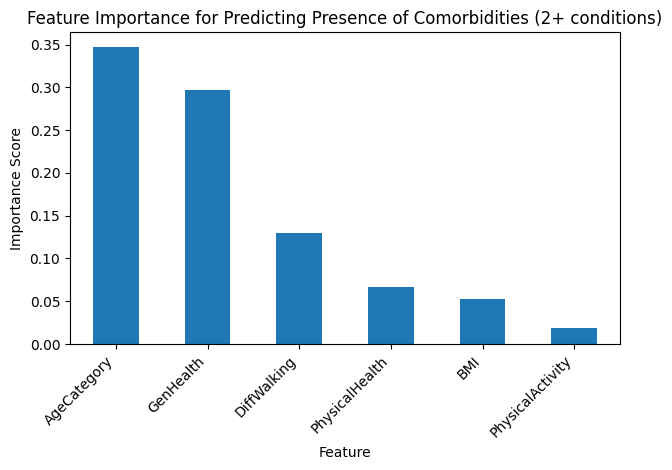

In [ ]:
plt.figure(figsize=(6, 4))
top_features = feature_importance_df.head(6)
top_features.set_index('Feature').plot(kind='bar', legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance for Predicting Presence of Comorbidities (2+ conditions)')
plt.tight_layout()
plt.show()

### Random Forest - Results and Summary:

**Model Setup:**
We trained Random Forest with the same balanced class weighting applied to logistic regression to handle the class imbalance. To address overfitting, we tuned `max_depth` using GridSearchCV with 3-fold cross-validation across values [3, 5, 7, 10, 12] . GridSearchCV identified `max_depth=10` as optimal, which eliminated the train-test gap between models.

**Results:**
- Accuracy (Train): 0.736, Accuracy (Test): 0.732
- Precision (Train): 0.277, Precision (Test): 0.267
- Recall (Train): 0.803, Recall (Test): 0.783
- ROC-AUC (Train): 0.845, ROC-AUC (Test): 0.831
- Confusion Matrix: 37,636 true negatives, 14,237 false positives, 1,430 false negatives, 5,174 true positives

**Feature Importance:**
- AgeCategory: 0.347 (34.7%)
- GenHealth: 0.297 (29.7%)
- DiffWalking: 0.130 (13.0%)

**Summary:**
- Train and test metrics match closely, indicating no overfitting
- Performance is marginally better than logistic regression (Recall: 0.783 vs 0.773, ROC-AUC: 0.831 vs 0.752)
- Catches 78% of at-risk individuals but flags 14,237 healthy people as at-risk (false positives)
- Feature importance reveals age, general health and difficulty walking as most effective indicators



## Predicting Stroke & Heart Disease (Cluster 3)

In this section, we will be using a variety of models to try to accurately predict when individuals will have both heart disease and a stroke by using demographics (excluding race) and lifestyle factors.

First we create training and testing data by:


*   Filtering for clusters 0-3 (excluding 4)
*   Combining clusters 0-2 into one group, denoted as healthy


*   The target will be the healthy column and features will be the rest of the columns excluding race





In [ ]:
# filter for clusters 0-3 , drop disease columns and condition count
drop_columns = disease_cols + ['condition_count']
cluster4_removed = df_kmeans_2_cluster.copy().drop(drop_columns, axis=1)
cluster4_removed = cluster4_removed[(cluster4_removed['cluster'] == 0) | (cluster4_removed['cluster'] == 1) | (cluster4_removed['cluster'] == 2) | (cluster4_removed['cluster'] == 3)]
cluster4_removed.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,cluster
0,16.60,1,0,3.0,30.0,0,1,7,1,3,5.0,0
1,20.34,0,0,0.0,0.0,0,1,12,1,3,7.0,3
2,26.58,1,0,20.0,30.0,0,0,9,1,1,8.0,2
3,24.21,0,0,0.0,0.0,0,1,11,0,2,6.0,0
4,23.71,0,0,28.0,0.0,1,1,4,1,3,8.0,1


In [ ]:
# group clusters 0-2 as healthy (0), cluster 3 as comorbid group (1)
healthy_v_diseased = cluster4_removed.copy()
healthy_v_diseased["Healthy"] = healthy_v_diseased['cluster'].map({0: 0, 1: 0, 2: 0, 3: 1})
healthy_v_diseased.drop("cluster", axis=1, inplace=True)
healthy_v_diseased.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Healthy
0,16.60,1,0,3.0,30.0,0,1,7,1,3,5.0,0
1,20.34,0,0,0.0,0.0,0,1,12,1,3,7.0,1
2,26.58,1,0,20.0,30.0,0,0,9,1,1,8.0,0
3,24.21,0,0,0.0,0.0,0,1,11,0,2,6.0,0
4,23.71,0,0,28.0,0.0,1,1,4,1,3,8.0,0


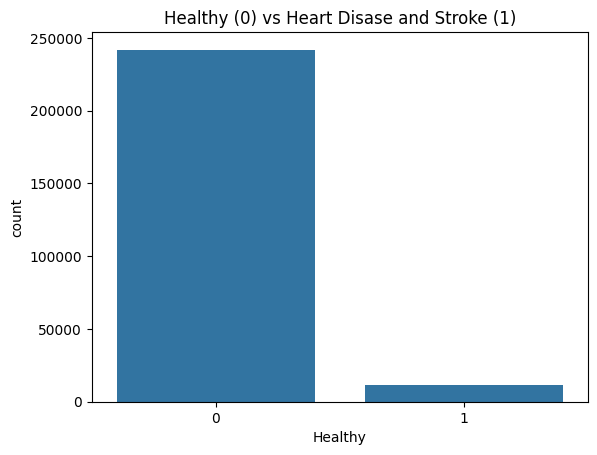

In [ ]:
cplot = sns.countplot(x='Healthy', data=healthy_v_diseased)
cplot.set_title("Healthy (0) vs Heart Disase and Stroke (1)")
plt.show()

Because few people have both heart disease and stroke comorbities and we grouped 3 other clusters into the healthy category, we now have a class imbalance.

In [ ]:
# split into features and target
features = healthy_v_diseased.copy()
features = healthy_v_diseased.drop("Healthy", axis=1)

# target = healthy column
target = healthy_v_diseased['Healthy']

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

To account for the class imbalance, we will use undersampling to see if it will improve our models performances.

In [ ]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

### Linear Regression

In [ ]:
# Train linear regression model
cluster3_lr = LinearRegression()
cluster3_lr.fit(X_train, y_train)

# Predict using trained model on test/train data
y_pred_train = cluster3_lr.predict(X_train)
y_pred_test = cluster3_lr.predict(X_test)

# Evaluate/Score

# R squared
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Root MSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# MSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"R2 score (training): {r2_score_train:.4f}")
print(f"R2 score (test): {r2_score_test:.4f}")
print(f"MAE (training): {mae_train:.4f}")
print(f"MAE (test): {mae_test:.4f}")
print(f"RMSE (training): {rmse_train:.4f}")
print(f"RMSE (test): {rmse_test:.4f}")
print(f"MSE (training): {mse_train:.4f}")
print(f"MSE (test): {mse_test:.4f}")

R2 score (training): 0.0670
R2 score (test): 0.0584
MAE (training): 0.0871
MAE (test): 0.0865
RMSE (training): 0.2023
RMSE (test): 0.2021
MSE (training): 0.0409
MSE (test): 0.0409


##Linear Regression Results:
- R^2 (Train): 0.0670, R^2 (Test): 0.0584
- MAE (Train): 0.0871, MAE (Test): 0.0865
- RMSE (Train): 0.2023, RMSE (Test): 0.2021
- MSE (Train): 0.0409, MSE (Test): 0.0409

The linear regression model has very similar train and test R^2 values, so its is not overfitting to the training data. And on average, the predictions from the model are only off by 0.0865. However, it only explains 6% of the variance, indicating the data likely non-linear and would be better explained by another model.


### Logistic Regression

In [ ]:
# Training
cluster3_lgr = LogisticRegression(max_iter=2000, class_weight='balanced')
cluster3_lgr.fit(X_train, y_train)

# Predict
y_pred_test = cluster3_lgr.predict(X_test)
y_pred_train = cluster3_lgr.predict(X_train)
# probabilities
y_prob_test = cluster3_lgr.predict_proba(X_test)[:, 1]

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# precision
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy (train): 0.7344
Accuracy (test): 0.7359
Precision: 0.1142
Recall: 0.7112
F1-score: 0.1967
ROC-AUC: 0.7970
Confusion Matrix:
[[35686 12727]
 [  666  1640]]


#### Logistic Regression Results:

- Accuracy (Train): 0.7344, Accuracy (Test): 0.7359
- Precision: 0.1142
- Recall: 0.7112
- F1-score: 0.1967
- ROC-AUC: 0.7970
- Confusion Matrix: 35,686 true negatives, 12,727 false positives, 666 false negatives, 1640 true positives

Similar to the logistic regression model used to determine multi-morbidity, the model failed to converge using the default values, so we set the maximum iterations to 2000. We saw earlier that the number of healthy people (class 0) vs those with heart disease and stroke (class 1) was imbalanced, so to address that, we applied a class_weight = 'balanced' which forced the model to apply more of a penalty to miscalssifying class 1.

The training and test accuracy are about the same which indicated no overfitting. If the goal is to use this model in a healthcare settings for diagnosis, we want to have a high recall to capture all cases of heart diease and stroke to ensure that people can get treated early or take preventative measures to reduce their risk, which this model does well. The logistic regression model captures 71% of people at risk for heart disease and stroke and misses very few people in that class (fn=666) and does well discriminating between classes 0 and 1 with an ROC-AUC score of 0.7970. However, if we wanted to use it as a screening tool where we prioritize having higher precision (fewer false positives), this model only does this at a rate of 11.42%.

### Decision Tree

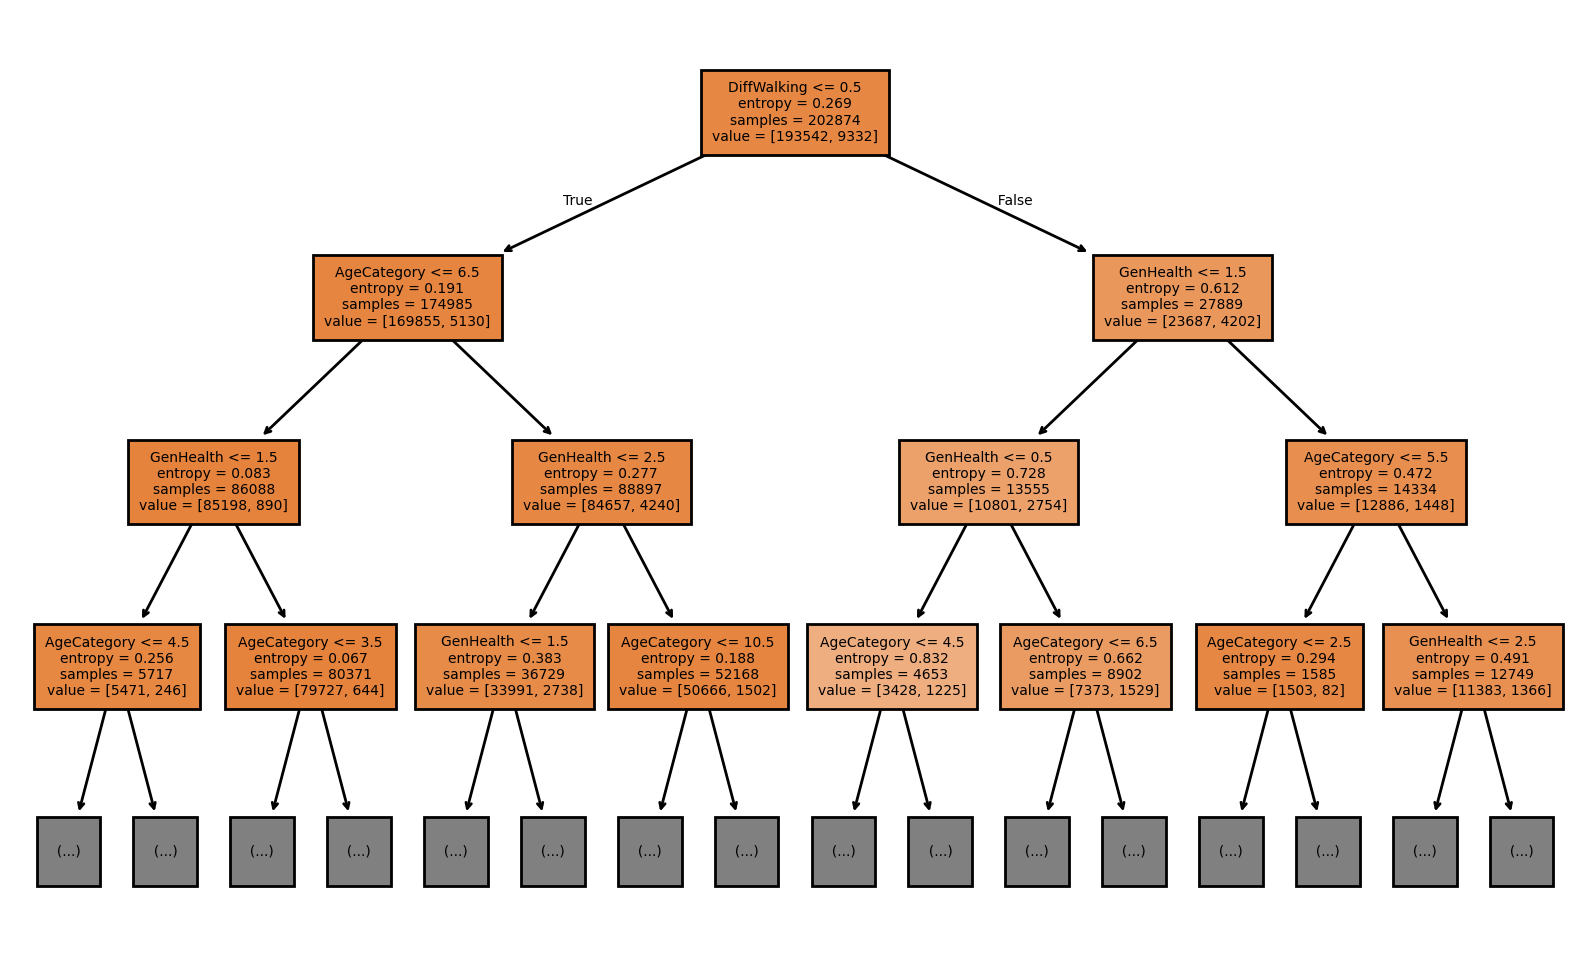

Training Accuracy: 0.9965
Testing Accuracy: 0.9170
Precision: 0.1167
Recall: 0.1258
F1-score: 0.1210
ROC-AUC: 0.5400
Confusion Matrix:
[[46217  2196]
 [ 2016   290]]


In [ ]:
# Train decision tree model, no hyperparameter tuning
cluster3_dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
cluster3_dt = cluster3_dt.fit(X_train, y_train)
# Predict using trained model on test/train data
y_hat_train = cluster3_dt.predict(X_train)
y_hat_test = cluster3_dt.predict(X_test)

# probabilities
y_prob_test = cluster3_dt.predict_proba(X_test)[:, 1]

# Evaluate/Score

cluster3_dt_train_acc = accuracy_score(y_train, y_hat_train)
cluster3_dt_test_acc = accuracy_score(y_test, y_hat_test)

# precision, recall, f1
prec = precision_score(y_test, y_hat_test)
rec = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(10,6), dpi=200)
plot_tree(cluster3_dt, max_depth=3, fontsize=5, feature_names=X_train.columns, filled=True)
plt.show()

print(f'Training Accuracy: {cluster3_dt_train_acc:.4f}')
print(f'Testing Accuracy: {cluster3_dt_test_acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

In [ ]:
feature_names = X_train.columns
cluster3_dt_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cluster3_dt.feature_importances_})
cluster3_dt_feature_importance_df = cluster3_dt_feature_importance_df.sort_values('Importance', ascending=False)
cluster3_dt_feature_importance_df

,Feature,Importance
0,BMI,0.414775
7,AgeCategory,0.109216
10,SleepTime,0.100147
3,PhysicalHealth,0.078288
5,DiffWalking,0.078026
4,MentalHealth,0.073088
9,GenHealth,0.042597
8,PhysicalActivity,0.032544
1,Smoking,0.030196
6,Sex,0.029849


## Decision Tree Results (no hyperparameter tuning or undersampling)
- Accuracy (Train): 0.9965, Accuracy (Test): 0.9170
- Precision: 0.1167
- Recall: 0.1258
- F1-score: 0.1210
- ROC-AUC: 0.5400
- Confusion Matrix: 46,217 true negatives, 2,196 false positives, 2,016 false negatives, 290 true positives
- Most important features: BMI (41.5%), AgeCategory (11%), SleepTime (10%)

Initially the decision tree model had a higher training accuracy compared to the testing accuracy which indicated the model was overfitting and we needed to do some hyperparameter tuning. The model also performs poorly in precision and recall and is not able to discriminate well between the two classes (ROC-AUC at 54%).

To address the models poor performance, we used GridSearch to iterate through different tuning parameters like max depth, min samples split and min samples leaf and find the best combination.

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 12, 15],
    'min_samples_split': [0.0001, 0.005, 0.01],
    'min_samples_leaf': [100, 500, 1000, 5000]
}

dt_search = GridSearchCV(
    DecisionTreeClassifier(criterion='entropy'),
    param_grid,
    cv=3,
    scoring='roc_auc'
)

dt_search.fit(X_train, y_train)
print(f"Best params: {dt_search.best_params_}")
print(f"Best CV ROC AUC: {dt_search.best_score_}")

y_pred_proba = dt_search.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

# ** Results **
# Best params: {'max_depth': 7, 'min_samples_leaf': 500, 'min_samples_split': 0.01}
# Best CV ROC AUC: 0.804197001604188
# Test ROC AUC: 0.7922004796508303

Best params: {'max_depth': 7, 'min_samples_leaf': 500, 'min_samples_split': 0.01}
Best CV ROC AUC: 0.804197001604188
Test ROC AUC: 0.7922004796508303


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


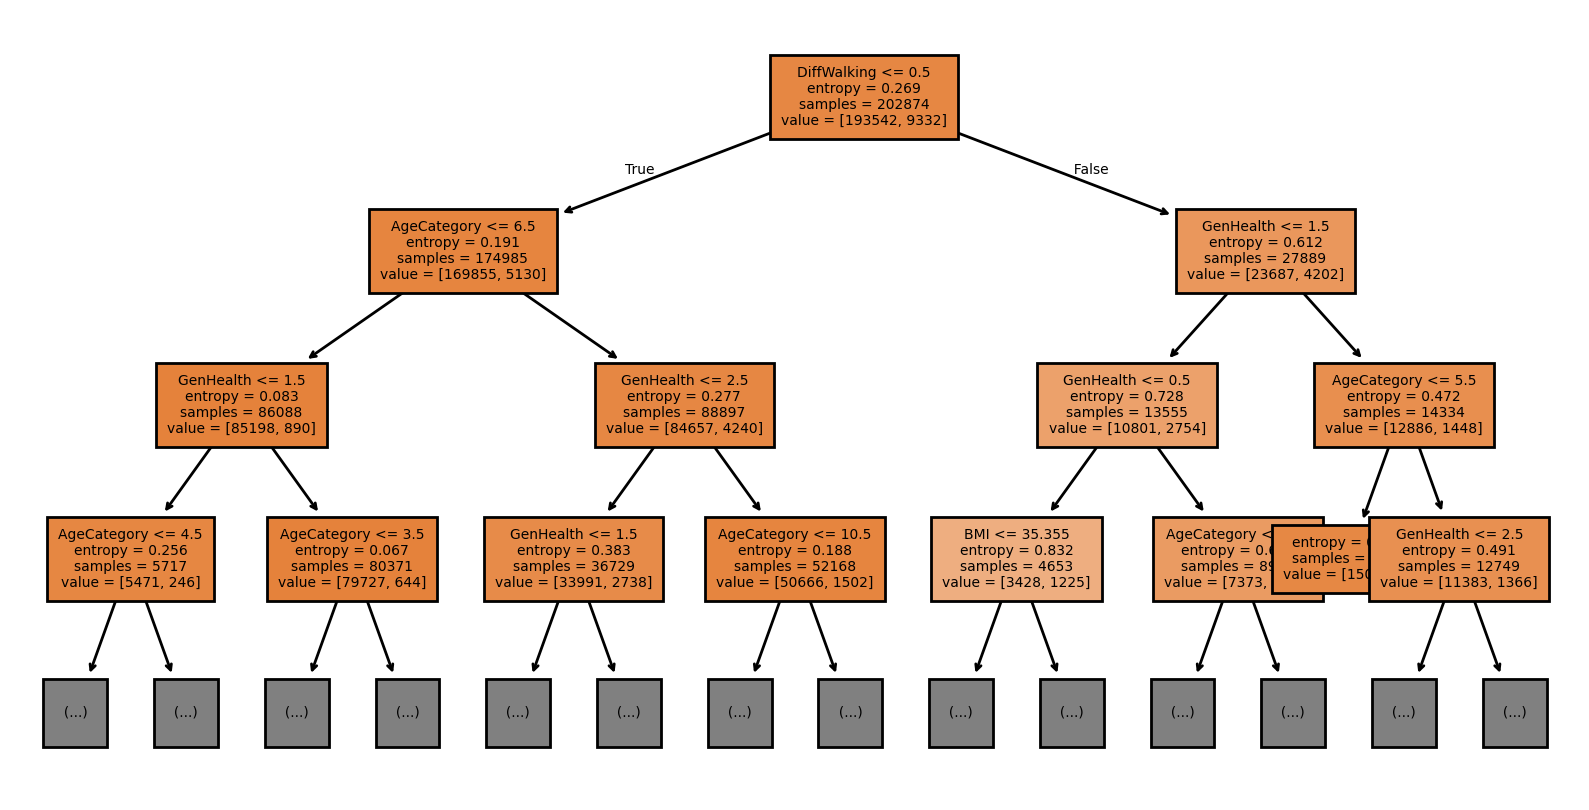

Training Accuracy: 0.9540
Testing Accuracy: 0.9545
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
ROC-AUC: 0.7922
Confusion Matrix:
[[48413     0]
 [ 2306     0]]


In [ ]:
# Train decision tree model with gridsearchcv's selected parameters
cluster3_dt_tuned = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf= 500, min_samples_split= 0.01, random_state=42)
cluster3_dt_tuned = cluster3_dt_tuned.fit(X_train, y_train)
# Predict using trained model on test/train data
y_hat_train = cluster3_dt_tuned.predict(X_train)
y_hat_test = cluster3_dt_tuned.predict(X_test)

# probabilities
y_prob_test = cluster3_dt_tuned.predict_proba(X_test)[:, 1]

# Evaluate/Score
cluster3_dt_tuned_train_acc = accuracy_score(y_train, y_hat_train)
cluster3_dt_tuned_test_acc = accuracy_score(y_test, y_hat_test)

# precision, recall, f1
prec = precision_score(y_test, y_hat_test)
rec = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(10,5), dpi=200)
plot_tree(cluster3_dt_tuned, max_depth=3, fontsize=5, feature_names=X_train.columns, filled=True)
plt.show()

print(f'Training Accuracy: {cluster3_dt_tuned_train_acc:.4f}')
print(f'Testing Accuracy: {cluster3_dt_tuned_test_acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

In [ ]:
feature_names = X_train.columns
cluster3_dt_tuned_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cluster3_dt_tuned.feature_importances_})
cluster3_dt_tuned_feature_importance_df = cluster3_dt_tuned_feature_importance_df.sort_values('Importance', ascending=False)
cluster3_dt_tuned_feature_importance_df

,Feature,Importance
5,DiffWalking,0.470552
7,AgeCategory,0.271466
9,GenHealth,0.217320
3,PhysicalHealth,0.013469
0,BMI,0.012285
4,MentalHealth,0.004645
10,SleepTime,0.004279
1,Smoking,0.003322
2,AlcoholDrinking,0.001875
8,PhysicalActivity,0.000438


##Decision Tree Results (with hyperparameter tuning, no undersampling)
- Accuracy (Train): 0.9540, Accuracy (Test): 0.9545
- Precision: 0.0000
- Recall: 0.0000
- F1-score: 0.0000
- ROC-AUC: 0.7922
- Confusion Matrix: 48413 true negatives, 0 false positives, 2,306 false negatives, 0 true positives
- Most important feature: DiffWalking (47%), AgeCategory (27.1%), GenHealth (21.7%)

After running GridSearchCV, we found the best parameters to be: max_depth: 7, min_samples_leaf: 500, min_samples_split: 0.01. When these parameters were used in the decision tree, the models test accuracy improved and now there is no overfitting. However, the model was unable to identify any true positives which lead to 0s in the precision, recall, and f1-score. This is probably due to the imbalanced classes noted earlier (most of the population is class 0= healthy). The next step will be to use the same hyperparameters, but also employ undersampling.

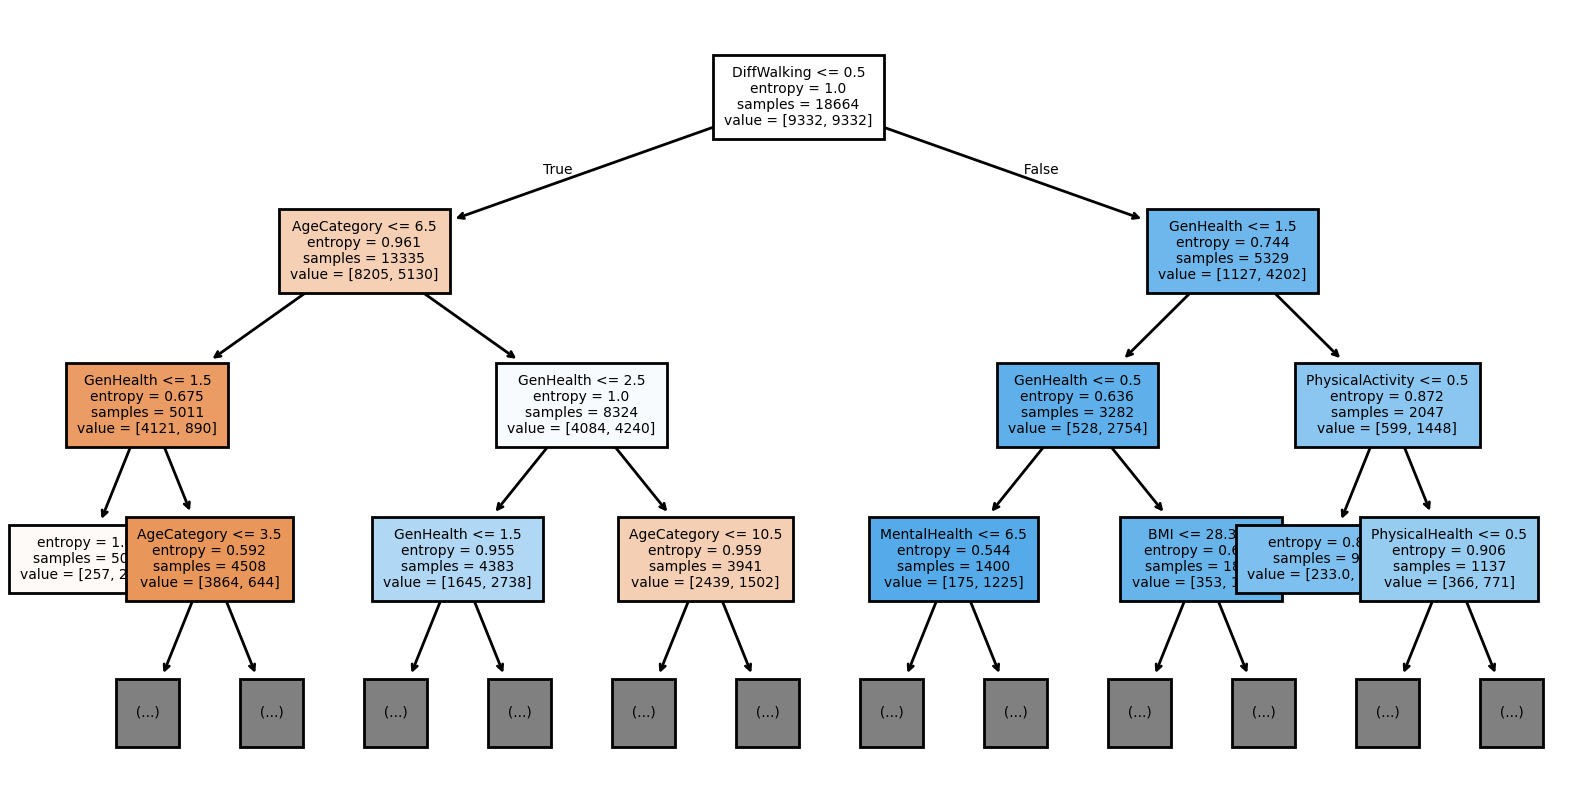

Training Accuracy: 0.6972
Testing Accuracy: 0.6997
Precision: 0.1055
Recall: 0.7493
F1-score: 0.1849
ROC-AUC: 0.7878
Confusion Matrix:
[[33760 14653]
 [  578  1728]]


In [ ]:
# Train decision tree model with hyperparameter tuning and undersampling
cluster3_dt_us = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf= 500, min_samples_split= 0.01, random_state=42)
cluster3_dt_us = cluster3_dt_us.fit(X_rus, y_rus)
# Predict using trained model on test/train data
y_hat_train = cluster3_dt_us.predict(X_train)
y_hat_test = cluster3_dt_us.predict(X_test)


# probabilities
y_prob_test = cluster3_dt_us.predict_proba(X_test)[:, 1]

# Evaluate/Score
cluster3_dt_us_train_acc = accuracy_score(y_train, y_hat_train)
cluster3_dt_us_test_acc = accuracy_score(y_test, y_hat_test)

# precision, recall, f1
prec = precision_score(y_test, y_hat_test)
rec = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(10,5), dpi=200)
plot_tree(cluster3_dt_us, max_depth=3, fontsize=5, feature_names=X_train.columns, filled=True)
plt.show()


print(f'Training Accuracy: {cluster3_dt_us_train_acc:.4f}')
print(f'Testing Accuracy: {cluster3_dt_us_test_acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

In [ ]:
feature_names = X_train.columns
cluster3_dt_us_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cluster3_dt_us.feature_importances_})
cluster3_dt_us_feature_importance_df = cluster3_dt_us_feature_importance_df.sort_values('Importance', ascending=False)
cluster3_dt_us_feature_importance_df

,Feature,Importance
5,DiffWalking,0.440420
7,AgeCategory,0.346725
9,GenHealth,0.191420
1,Smoking,0.005633
3,PhysicalHealth,0.005196
4,MentalHealth,0.005180
0,BMI,0.003623
8,PhysicalActivity,0.001803
2,AlcoholDrinking,0.000000
6,Sex,0.000000


##Decision Tree Results (with hyperparameter tuning and undersampling)
- Accuracy (Train): 0.6859, Accuracy (Test): 0.6881
- Precision: 0.1028
- Recall: 0.7585
- F1-score: 0.1811
- ROC-AUC: 0.7898
- Confusion Matrix: 33153 true negatives, 15260 false positives, 557 false negatives, 1749 true positives
- Most important feature: DiffWalking (42.5%), AgeCategory (34.6%), GenHealth (20.9%)

By using hyperparameter tuning and undersampling, we were able to stop the model from overfitting and reduce the class imbalance. This drastically improved the recall, capturing about 75.9% of all positve cases, which would make it a meaningful model for diagnostics. Unfortunately, the precision is pretty low at only 10.3% and there are 15260 false positives, so the model would not be able to be used for screening. The model also revealed that the most import lifestyle indicators for having heart disease and a stroke are difficulty walking, age, and general health.

### Random Forest

In [ ]:
cluster3_rf = RandomForestClassifier(random_state=42, max_depth=5, class_weight="balanced")
cluster3_rf.fit(X_train, y_train)
y_pred_train = cluster3_rf.predict(X_train)
y_pred_test = cluster3_rf.predict(X_test)

# probabilities
y_prob_test = cluster3_rf.predict_proba(X_test)[:, 1]

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# precision
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy (train): 0.7316
Accuracy (test): 0.7346
Precision: 0.1135
Recall: 0.7103
F1-score: 0.1957
ROC-AUC: 0.7953
Confusion Matrix:
[[35618 12795]
 [  668  1638]]


In [ ]:
feature_names = X_train.columns
cluster3_rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cluster3_rf.feature_importances_})
cluster3_rf_feature_importance_df = cluster3_rf_feature_importance_df.sort_values('Importance', ascending=False)
cluster3_rf_feature_importance_df

,Feature,Importance
7,AgeCategory,0.320325
9,GenHealth,0.276417
5,DiffWalking,0.240068
3,PhysicalHealth,0.095957
8,PhysicalActivity,0.021713
1,Smoking,0.019235
10,SleepTime,0.011109
4,MentalHealth,0.007451
0,BMI,0.005387
2,AlcoholDrinking,0.001788


##Random Forest Results (class balancing)
- Accuracy (Train): 0.7316, Accuracy (Test): 0.7346
- Precision: 0.1135
- Recall: 0.7103
- F1-score: 0.1957
- ROC-AUC: 0.7953
- Confusion Matrix: 35618 true negatives, 12795 false positives, 668 false negatives, 1638 true positives
- Most important feature: AgeCategory (32%), GenHealth (27.6%), DiffWalking (24%)

For the first attempt at a random forest model, we addressed the class imbalance by using class_weight='balanced' and we addressed overfitting (training and test accuracy are about the same) by setting a max depth of 5. Similar to the decision tree, this model has a high recall, capturing 71% of all positives but has low precision (11.4%) and there a high number of false positives (12795).

To try to improve the models recall, we used GridSearch to iterate through different tuning parameters like max depth, min samples split and min samples leaf and find the best combination.

In [ ]:
# DO NOT RE-RUN THIS CELL. The gridsearch will take 20+ mins
# param_grid = {
#     'max_depth': [10, 12, 15, 20, 25],
#     'min_samples_split': [0.001, 0.005, 0.01],
#     'min_samples_leaf': [10, 50, 100]
# }

# rf_search = GridSearchCV(
#     RandomForestClassifier(random_state=42, class_weight='balanced'),
#     param_grid,
#     cv=3,
#     scoring='roc_auc'
# )

# rf_search.fit(X_train, y_train)
# print(f"Best params: {rf_search.best_params_}")
# print(f"Best CV ROC AUC: {rf_search.best_score_}")

# y_pred_proba = rf_search.predict_proba(X_test)[:, 1]
# print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

# ** Results **
# Best params: {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 0.001}
# Best CV ROC AUC: 0.8111749842822412
# Test ROC AUC: 0.7989379210091889

Best params: {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 0.001}
Best CV ROC AUC: 0.8111749842822412
Test ROC AUC: 0.7989379210091889


In [ ]:
cluster3_rf_tuned = RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=100, min_samples_split= 0.001, class_weight="balanced")
cluster3_rf_tuned.fit(X_train, y_train)
y_pred_train = cluster3_rf_tuned.predict(X_train)
y_pred_test = cluster3_rf_tuned.predict(X_test)

# probabilities
y_prob_test = cluster3_rf_tuned.predict_proba(X_test)[:, 1]

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# precision
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy (train): 0.7232
Accuracy (test): 0.7237
Precision: 0.1120
Recall: 0.7329
F1-score: 0.1943
ROC-AUC: 0.7989
Confusion Matrix:
[[35013 13400]
 [  616  1690]]


In [ ]:
feature_names = X_train.columns
cluster3_rf_tuned_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cluster3_rf_tuned.feature_importances_})
cluster3_rf_tuned_feature_importance_df = cluster3_rf_tuned_feature_importance_df.sort_values('Importance', ascending=False)
cluster3_rf_tuned_feature_importance_df

,Feature,Importance
7,AgeCategory,0.326872
9,GenHealth,0.248979
5,DiffWalking,0.204688
3,PhysicalHealth,0.091335
0,BMI,0.033792
10,SleepTime,0.023321
1,Smoking,0.021958
8,PhysicalActivity,0.020673
4,MentalHealth,0.018571
6,Sex,0.005867


##Random Forest Results (after hyperparameter tuning)
- Accuracy (Train): 0.7232, Accuracy (Test): 0.7237
- Precision: 0.1120
- Recall: 0.7329
- F1-score: 0.1943
- ROC-AUC: 0.7989
- Confusion Matrix: 35013 true negatives, 13400 false positives, 616 false negatives, 1690 true positives
- Most important feature: AgeCategory (32.7%), GenHealth (24.9%), DiffWalking (20.5%)

After running GridSearchCV, we found the best parameters to be: max_depth: 10, min_samples_leaf: 100, min_samples_split: 0.001. When these parameters were used in the decision tree we were able to maintain the accuracy of the model, prevent overfitting, and improve the recall (73.29%). The model does a good job at distinguishing between classes with a ROC-AUC at 80%. The poor precision was maintained at only 11% as well as the high number of false positives (13400) so this model does a better job at diagnosing but is not very precise.



## Predicting Diabetes & Kidney Disease (Cluster 4)

In [ ]:
# filter for clusters 0-2 & 4, drop disease columns
drop_columns = disease_cols
cluster3_removed = df_kmeans_2_cluster.copy().drop(drop_columns, axis=1)
cluster3_removed = cluster3_removed[(cluster3_removed['cluster'] == 0) | (cluster3_removed['cluster'] == 1) | (cluster3_removed['cluster'] == 2) | (cluster3_removed['cluster'] == 4)]
cluster3_removed.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,condition_count,cluster
0,16.60,1,0,3.0,30.0,0,1,7,1,3,5.0,3.0,0
2,26.58,1,0,20.0,30.0,0,0,9,1,1,8.0,2.0,2
3,24.21,0,0,0.0,0.0,0,1,11,0,2,6.0,1.0,0
4,23.71,0,0,28.0,0.0,1,1,4,1,3,8.0,0.0,1
5,28.87,1,0,6.0,0.0,1,1,11,0,1,12.0,1.0,1


In [ ]:
# group clusters 0-2 as healthy (0), cluster 4 as comorbid group (1)
healthy_v_diseased = cluster3_removed.copy()
healthy_v_diseased["Healthy"] = healthy_v_diseased['cluster'].map({0: 0, 1: 0, 2: 0, 4: 1})
healthy_v_diseased.drop("cluster", axis=1, inplace=True)
healthy_v_diseased.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,condition_count,Healthy
0,16.60,1,0,3.0,30.0,0,1,7,1,3,5.0,3.0,0
2,26.58,1,0,20.0,30.0,0,0,9,1,1,8.0,2.0,0
3,24.21,0,0,0.0,0.0,0,1,11,0,2,6.0,1.0,0
4,23.71,0,0,28.0,0.0,1,1,4,1,3,8.0,0.0,0
5,28.87,1,0,6.0,0.0,1,1,11,0,1,12.0,1.0,0


In [ ]:
# split into features and target
features = healthy_v_diseased.copy()
features = healthy_v_diseased.drop("Healthy", axis=1)

# target = healthy column
target = healthy_v_diseased['Healthy']

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Linear Regression

In [ ]:
# Train linear regression model
cluster4_lr = LinearRegression()
cluster4_lr.fit(X_train, y_train)

# Predict using trained model on test/train data
y_pred_train = cluster4_lr.predict(X_train)
y_pred_test = cluster4_lr.predict(X_test)

# Evaluate/Score

# R squared
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Root MSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R2 score (training): {r2_score_train}")
print(f"R2 score (test): {r2_score_test}")
print(f"MAE (training): {mae_train}")
print(f"MAE (test): {mae_test}")
print(f"RMSE (training): {rmse_train}")
print(f"RMSE (test): {rmse_test}")

R2 score (training): 0.2050200363438338
R2 score (test): 0.19075962547911762
MAE (training): 0.07658566448358521
MAE (test): 0.074703423255488
RMSE (training): 0.17492260034994653
RMSE (test): 0.17079901940495348


#### Linear Regression Results

The evaluation of this model seems to be that it is stable and not overfitting based on the comparison of the scores between the training data and test data, but the model is not making an real meaningful predictions. This infers that a nonlinear model may be better for prediction.

### Random Forest

In [ ]:
# Training
cluster4_rf = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=50, class_weight="balanced")
cluster4_rf.fit(X_train, y_train)

# Prediction
y_pred_train = cluster4_rf.predict(X_train)
y_pred_test = cluster4_rf.predict(X_test)

# probabilities
y_prob_test = cluster4_rf.predict_proba(X_test)[:, 1]

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# precision
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy (train): 0.7484
Accuracy (test): 0.7475
Precision: 0.1291
Recall: 1.0000
F1-score: 0.2288
ROC-AUC: 0.9202
Confusion Matrix:
[[35774 12724]
 [    0  1887]]


#### Random Forest Results

Initially, class_weight = 'balanced' was excluded and the results led to the majority class being picked most of the time, accuracy was high, but precision and recall was very low. Adding the class_weight parameter more equally balanced the classes improving the precision and recall score.

Accuracy for both the training and test sets is nearly identical (~75%), suggesting the model is not overfitting. However, this level of accuracy also indicates that a number of healthy individuals are being misclassified. The precision of 0.13 confirms this when the model predicts someone is diseased, it could be incorrect.

The recall of 1.00 shows that the model successfully identifies every diseased individual. This comes at the cost of many false positives, but it makes the Random Forest act like a screening tool, highly sensitive, but not specific. In medical contexts, this is the behavior of a model designed to catch everyone at risk, even if that means misclassifying some.


### Logistic Regression

In [ ]:
# Training
cluster4_lgr = LogisticRegression(max_iter=2000, class_weight='balanced')
cluster4_lgr.fit(X_train, y_train)


# Predict
y_pred_train = cluster4_lgr.predict(X_train)
y_pred_test = cluster4_lgr.predict(X_test)

# probabilities
y_prob_test = cluster4_lgr.predict_proba(X_test)[:, 1]

# acc
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# precision
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# roc-auc
auc = roc_auc_score(y_test, y_prob_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)


Accuracy (train): 0.8709
Accuracy (test): 0.8719
Precision: 0.2002
Recall: 0.8087
F1-score: 0.3210
ROC-AUC: 0.9351
Confusion Matrix:
[[42403  6095]
 [  361  1526]]


#####Logistic Regession Results

Similar to Random Forest, the class_weight = 'balanced' was excluded and the results led to the majority class being picked most of the time, accuracy was high, but precision and recall was very low. Adding the class_weight parameter more equally balanced the classes improving the precision and recall score.

Additionally, standardization was attempted in an earlier version, and perfect scores were observed. This version was removed because the results were likely due to perfect separation rather than model performance.

Logistic regression also shows similar accuracy between the training (87%) and test (87%) sets, again suggesting no overfitting. Accuracy is higher than the Random Forest model, meaning it classifies healthy individuals more correctly.

Precision (0.20) is higher than Random Forest, and while recall (0.81) is lower, it is still strong. The F1-score and AUC are the highest among all models, indicating that logistic regression provides the most balanced performance between catching diseased individuals and avoiding false positives.

Overall, Logistic Regression sacrifices some sensitivity in exchange for better specificity and overall classification.

### Best Model for Predicting Condition Count and Multi-Morbidity

For predicting condition count, Linear Regression and Random Forest achieved comparable performance (R^2  0.21 vs 0.24). This indicates the demographic and lifestyle factors in this dataset have limited predictive power for predicting condition count. For multi-morbidity classification, Random Forest marginally outperformed Logistic Regression. Both models successfully identified at-risk individuals with high recall, though at the cost of high false positive rates. For a screening tool with good sensitivity, Random Forest is the better choice.

### Best Model for Predicting Heart Disease and Stroke


For predicting heart disease and stroke risk, logistic regression, decision trees, and random forest had a similar test accuracy of around 70% +/- 3%. Similarly all three did well at identifying high risk individuals with high recalls of >70%. For diagnostic purposes, the decision tree classifier outperformed the other two models, with a recall rate of ~76% and would therefore be the best choice. None of these models had high precision as they were all tuned to try to improve the recall rate. Because of this, none of these models would be appropriate as a screening tool.

### Best Model for Predicting Diabetes & Kidney Disease

If the purpose of the model is to serve as a broad lifestyle based screening tool where the priority is to avoid missing any potentially at risk individuals, Random Forest is the better choice due to its perfect recall (1.0).

If the goal is to identify disease risk more accurately while minimizing unnecessary flags, Logistic Regression is the stronger, more balanced model.

With our project goal in mind, Random Forest is the best model fit for our needs. However, a future improvement or potential next steps could be moving closer to a diagnostics tool over a screening tool in which Logistic Regression would be the better fit.


## Description of Challenges / Obstacles Faced

1. Issues with original dataset: We initially selected "Health and Fitness Tracking 365 Days for 1000 Users" from Kaggle. After data cleaning and EDA, we discovered this synthetic dataset contained no meaningful correlations between features and health outcomes. It was completely randomized data. This made predictive modeling impossible. We pivoted to the "Indicators of Heart Disease" dataset, which contained stronger relationships between lifestyle factors and health outcomes.

2. Class Imbalances: Many of the classification tasks suffered from class imbalances. We addressed this through balancing the class weights, but this created an inherent tradeoff between precision and recall. Ultimately we decided to tune our models to prioritize recall to catch at-risk
individuals. This is clinically more important than avoiding false positives, even if it means flagging some healthy individuals for further evaluation.

3. Overfitting in Tree-Based Models: Random Forest models with default parameters exhibited overfitting.  Hyperparameter tuning via GridSearchCV was used to better generalize the model.

4. Predicting Condition Count: Demographic and lifestyle factors alone were not enough to predict condition count reliably. This suggests there may be some unmeasured factors (genetics, healthcare access, medical history) that drive health outcomes more strongly than the variables in this dataset.

5. KMeans Clustering: KMeans clustering was first run using all available features in the dataset. However, race related variables dominated the cluster separation overshadowing patterns related to comorbidities and lifestyle factors. For a clearer separation, race columns were removed. Although it was removed for our analysis, race definitely holds important insights into comorbidities and a separate race focused analysis could be a future expansion of this project.

## Potential Next Steps/Future Direction

Based on the results of this project, there are several clear opportunities to expand this analysis.

1. Model Performance: Although the predictive models completed above produced meaningful insights, the high false positive rate suggest, in its current state, this is best as a screening tool, rather than diagostics. Additional work with neural networks or  dimensionality reduction (PCA) could potentially be a way to improve the performance of this model for a potential diagnostics tool.

2. Develop a Lifestyle Based Screening Tool: Desipite imperfect accuracy, the model identified consistent lifestyle factors of comorbidity risk which means this has the potential to function as a preventative screening tool. A future application could take in a patient's current lifestyle inputs, flag elevated risk for the two comorbidity groups (Heart Disease + Stroke, Kidney Disease + Diabetes), and provide personalized recommendations for lifestyle adjustments. This would not replace diagnostics, but identify at risk patients earlier.

3. Build a Recommendation Engine: Given that both comorbidity groups are associated with similar lifestyle factors (alcohol use, mental health indicators, smoking, physical health), an automated recommendation system could be integrated. We think simple, actionable suggestions in a take home PDF plan could reduce at risk individuals. For example:
  * Alcohol Use: Replace one alcoholic drink with a non-alcoholic option or reduce drinking frequency by one day per week.
  * Mental Health: Incorporate daily breathing exercises, mindfulness, or guided meditation.
  * Smoking: Reduce cigarette count or use nicotine replacement options.
  * Physical Activity: Get 500 more steps in per day.

4. Extend Clustering: This project successfully used KMeans to discover two major comorbidity structures. Further clustering could be done in subgroups such as age, sex, socioeconmic status, and race. Additionally, more features could improve clustering such as family history.

5. Incorporate Time Data: Track individuals changes in lifestyle factors over time and how that increases or decreases risk categories.

6. Put into Clinical Practice: Embed the model into patient intake forms to flag individuals that may need early intervention.